# Hi Jon
I know this is already really late, but I haven't managed to find time to finish it. There's been a bunch of stuff happening this week and I didn't get around to doing the last question. I'll probably come back to it eventually to finish though; this is by far my favourite assignment yet so I'm a bit bummed I didn't get to spend the time on it I wanted to. But yeah I figured I should probably turn it in at some point!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower

## a) getting CAMB going

In [2]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5,  ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)

results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers:
    print(name)

total
lens_potential
lensed_scalar
unlensed_scalar
unlensed_total
tensor


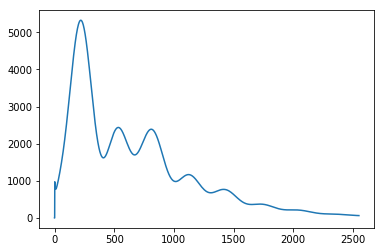

In [3]:
totCL = powers['total']
unlensedCL = powers['unlensed_scalar']
ls = np.arange(totCL.shape[0])
plt.plot(ls, totCL[:,0])

## plotting the WMAP data, then plotting it with the camb-generated spectrum

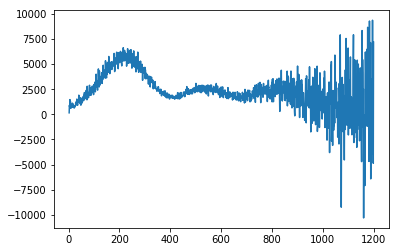

In [4]:
filename = 'wmap_tt_spectrum_9yr_v5.txt'
with open(filename, 'r') as f:
    raw = f.readlines()
    l = []
    ccl = [] # curly cl
    for line in raw:
        if not line.startswith('#'):
            l.append(float(line.split()[0]))
            ccl.append(float(line.split()[1]))

plt.plot(l, ccl)
    

1199
2551


Text(0,0.5,'C_l')

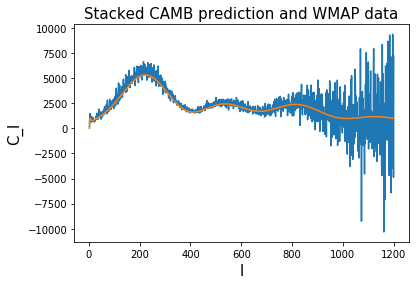

In [6]:
print(len(ccl))
print(len(totCL[:,0]))
plt.plot(l, ccl)
camb_cl = totCL[:,0]
plt.plot(l, camb_cl[:len(ccl)])
plt.title('Stacked CAMB prediction and WMAP data', fontsize=15)
plt.xlabel('l', fontsize=15)
plt.ylabel('C_l', fontsize=15) # curly Cl?

## Markov-Chain Monte Carlo (MCMC)
- start a variable at a guess
- take a trial step (a random amount added to each variable)
- if $\chi^2$ improves, accept the step
- if $\chi^2$ does not improve, accept the step occasionally
    - with probability $e^{-0.5\delta \chi^2}$, where $\delta \chi^2$ is the change in $\chi^2$ due to the step just taken
    


In [7]:
def update_model(params, cosmology):
    pcopy = pars.copy()
    pcopy.set_cosmology(ombh2=cosmology[0],omch2=cosmology[1],H0=cosmology[3],tau=cosmology[5])
    pcopy.InitPower.set_params(As=cosmology[2], ns=cosmology[4])
    return pcopy

def get_chi2(data, cosmology, params):
    updated = update_model(params, cosmology)
    results = camb.get_results(updated)
    ps = results.get_cmb_power_spectra(updated, CMB_unit='muK')['total'][:,0]
    l = np.asarray(data[:,0], dtype='int')
    delta_ps = data[:,1] - ps[l]
    chi2 = np.sum((delta_ps/data[:,2])**2)
    return chi2
    
def mcmc(data, cosmology, params, stepsize, n):
    chi2 = get_chi2(data, cosmology, params)
    chain = np.zeros([n, len(cosmology)+1]) # number of steps by number of cosmology parameters + chi2
    falsecount = 0
    for i in range(n):
        print(i)
        newcosmology = cosmology + np.random.randn(len(stepsize))*stepsize
        newChi2 = get_chi2(data, newcosmology, params)
        acceptanceChance = np.exp(-0.5*(newChi2 - chi2))
        random = np.random.rand()
        
        if random < acceptanceChance:
            accept = True
            cosmology = newcosmology
            chi2 = newChi2
        else:
            accept = False
            falsecount = falsecount + 1
        chain[i, 0] = chi2
        chain[i, 1:] = cosmology
        print(chi2, newChi2, acceptanceChance, random, cosmology, newcosmology, accept)
        
    return chain, falsecount

wmap = np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
params = camb.CAMBparams()
#from CAMB H0=67.5,  ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06
cosmology = np.asarray([0.02, 0.12, 2.125e-9, 70, 1, 0.05]) # ombh2, omch2, As, H0, ns, tau
chi2 = get_chi2(wmap, cosmology, params)
#stepsize = np.asarray([0.001, 0.001, 1e-11, 0.5, 0.01, 0.0001])
stepscale = 0.001
stepsize = np.asarray([0.02*stepscale, 0.12*stepscale, 2.12e-9*stepscale, 70*stepscale, 1*stepscale, 0.05*stepscale])

#chain = mcmc(wmap, cosmology, params, stepsize, 0)[0]

        

## b) 1-d curvatures
- first, change one parameter at a time in order to see how the chain evolves for each
    - is this with the goal of figuring out the right step size to use for each parameter, or to check that our guesses are roughly right?

0
(1495.5946831728297, 1642.1317720418083, 1.513127258507177e-32, 0.8909022250800115, array([2.000e-02, 1.200e-01, 2.125e-09, 7.000e+01, 1.000e+00, 5.000e-02]), array([1.90235985e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
1
(1495.5946831728297, 1555.1353940098443, 1.1773319162271608e-13, 0.9902184434481236, array([2.000e-02, 1.200e-01, 2.125e-09, 7.000e+01, 1.000e+00, 5.000e-02]), array([1.95772717e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
2
(1486.101456670433, 1486.101456670433, 115.1934917221448, 0.08436689490997618, array([2.00715538e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00715538e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
3
(1486.101456670433, 1499.4653094903933, 0.001253361157978415, 0.511948017206619, array([2.00715538e-02, 1.20000000e-01, 2.1250

(1239.119662955114, 1255.2706074743123, 0.00031107632446792635, 0.6321000318980631, array([2.38184612e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.28387094e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
28
(1240.3955561028322, 1240.3955561028322, 0.5283762925316031, 0.09822914059597632, array([2.35125367e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.35125367e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
29
(1240.3955561028322, 1249.4668316887764, 0.010720067861752855, 0.8395523994565811, array([2.35125367e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.30263586e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
30
(1240.3955561028322, 1249.328593712219, 0.01148723

(1245.3564371168088, 1276.398313906937, 1.816946338387026e-07, 0.8429238490239368, array([2.31943407e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.23486566e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
55
(1249.277735408062, 1249.277735408062, 0.14076701296488509, 0.09190413655600349, array([2.30333174e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.30333174e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
56
(1249.277735408062, 1279.5159111789421, 2.715585993169247e-07, 0.4585624453046656, array([2.30333174e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.22897858e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
57
(1247.11545425737, 1247.11545425737, 2.9480400960764

(1241.2454205549398, 1241.2454205549398, 0.364923170566298, 0.2684892065315664, array([2.41208423e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.41208423e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
82
(1241.2454205549398, 1253.8944079231392, 0.0017918732748318407, 0.7605666976055385, array([2.41208423e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.46736654e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
83
(1241.1134028455667, 1241.1134028455667, 1.0682361760205787, 0.8224601410684003, array([2.41095345e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.41095345e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
84
(1239.2841269102482, 1239.2841269102482, 2.495871502119

(1239.2869288712277, 1239.2869288712277, 4.211176714455851, 0.7237394288134363, array([2.38821629e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.38821629e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
109
(1239.2869288712277, 1245.886223241285, 0.03689618263073794, 0.8749012279665589, array([2.38821629e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.31701088e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
110
(1239.2869288712277, 1240.06908844807, 0.6763261908874565, 0.8896241502462516, array([2.38821629e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.40094085e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
111
(1239.611209418446, 1239.611209418446, 0.850321918449676

(1239.324460616399, 1239.324460616399, 2.5846156767971964, 0.9791750799777323, array([2.38907901e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.38907901e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
136
(1239.324460616399, 1250.5917864153682, 0.003575454780905892, 0.3257948082302361, array([2.38907901e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.45674444e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
137
(1239.116486099491, 1239.116486099491, 1.1095863169803173, 0.3975762196570619, array([2.37409733e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.37409733e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
138
(1239.103721035472, 1239.103721035472, 1.006402943770082,

(1239.1944220896373, 1239.1944220896373, 0.9527137241214623, 0.3309672689169927, array([2.37044133e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.37044133e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
163
(1239.1944220896373, 1252.6213212262194, 0.0012144675019098818, 0.43719478757269403, array([2.37044133e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.46341531e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
164
(1239.1944220896373, 1243.3391006822685, 0.12589094076543314, 0.48945132356402266, array([2.37044133e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.32976264e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
165
(1239.1944220896373, 1251.3263377219819, 0.0023

(1241.5089378981936, 1241.5089378981936, 0.3218134926801162, 0.05364116114798678, array([2.41404285e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.41404285e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
189
(1239.7907450838015, 1239.7907450838015, 2.361026323154506, 0.6161923379791733, array([2.39735527e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.39735527e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
190
(1239.7907450838015, 1240.538039206699, 0.688219768257701, 0.9182108273370853, array([2.39735527e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.34982863e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
191
(1241.5299736331513, 1241.5299736331513, 0.4191131806408

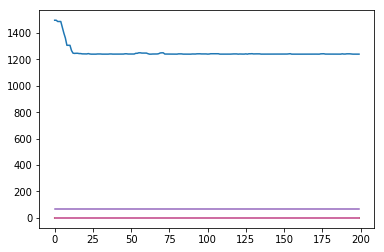

In [8]:
# ombh2, omch2, As, H0, ns, tau
# from CAMB H0=67.5,  ombh2=0.022, omch2=0.122, omk=0, tau=0.06
# ombh2

stepsize = np.zeros(len(cosmology))
stepsize[0] = 0.0005
curve_ombh = mcmc(wmap, cosmology, params, stepsize, 200)[0]

OMBH mean: 0.023722249798343118 std: 0.00026889695920316484


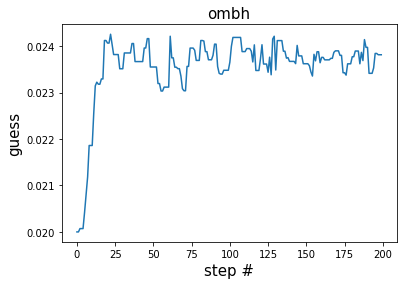

In [14]:
plt.plot(curve_ombh[:,1])
plt.title('ombh', fontsize='15')
plt.xlabel('step #', fontsize='15')
plt.ylabel('guess', fontsize='15')
burnend = 25
print('OMBH mean: ' +str(np.mean(curve_ombh[burnend:,1])) + ' std: ' + str(np.std(curve_ombh[burnend:,1])))

In [15]:
# omch2

stepsize = np.zeros(len(cosmology))
stepsize[1] = 0.005
result = mcmc(wmap, cosmology, params, stepsize, 200)
curve_omch = result[0]


0
(1476.0741628443184, 1476.0741628443184, 17331.140031688596, 0.7152361086433253, array([2.00000000e-02, 1.13748145e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.13748145e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
1
(1473.3624463745425, 1473.3624463745425, 3.880089556294204, 0.4640937425693715, array([2.00000000e-02, 1.14160301e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.14160301e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
2
(1473.3624463745425, 1551.4053506364767, 1.130312846743102e-17, 0.8725331114941454, array([2.00000000e-02, 1.14160301e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.09037961e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
3
(1473.3624463745425, 1484.5972948716694, 0.0036339893176

(1469.1304763558605, 1538.3589264744344, 9.273273342392402e-16, 0.2021413997414906, array([2.00000000e-02, 1.15302596e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.22662512e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
28
(1469.1304763558605, 1487.152742773685, 0.00012204347687192588, 0.7080312725409165, array([2.00000000e-02, 1.15302596e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.12539785e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
29
(1471.2170941345698, 1471.2170941345698, 0.352287072335145, 0.2973945664771186, array([2.0000000e-02, 1.1707578e-01, 2.1250000e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.1707578e-01, 2.1250000e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), True)
30
(1471.2170941345698, 1472.788161093128, 0.45587643627025526, 0.

(1469.4536289256075, 1493.352342253655, 6.463389650890497e-06, 0.48310439419084106, array([2.00000000e-02, 1.16492377e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.19817462e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
54
(1469.4536289256075, 1495.0400805195538, 2.7795380949199046e-06, 0.7197849905952423, array([2.00000000e-02, 1.16492377e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.19955583e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
55
(1469.4536289256075, 1471.7630839045355, 0.3151434051011305, 0.7303586639247716, array([2.00000000e-02, 1.16492377e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.17190312e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
56
(1469.4536289256075, 1534.4330415233458, 7.76068

(1471.4739460818892, 1471.4739460818892, 0.7665775782893202, 0.6855753239432361, array([2.00000000e-02, 1.14567053e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.14567053e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
81
(1471.4739460818892, 1520.8647153877773, 1.8833486138206565e-11, 0.032167523595033276, array([2.00000000e-02, 1.14567053e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.10392966e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
82
(1471.4739460818892, 1490.9670717581466, 5.8495376670170344e-05, 0.16404299691301427, array([2.00000000e-02, 1.14567053e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.0000000e-02, 1.1961575e-01, 2.1250000e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), False)
83
(1471.4739460818892, 1632.2616002410555, 1.21731933

(1469.364931959999, 1498.8887411976898, 3.8813810542228143e-07, 0.8595239596084571, array([2.00000000e-02, 1.15220499e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20255489e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
107
(1469.891523038347, 1469.891523038347, 0.7685147375347621, 0.055987184561622216, array([2.00000000e-02, 1.16669077e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.16669077e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
108
(1469.891523038347, 1500.3298948007464, 2.4569230386769225e-07, 0.09783218080802702, array([2.00000000e-02, 1.16669077e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20362855e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
109
(1469.891523038347, 1501.5798637192531, 1.3151

(1468.769945430774, 1490.03783813449, 2.4084397064238194e-05, 0.29854739863856017, array([2.00000000e-02, 1.15995092e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.19534611e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
133
(1468.769945430774, 1637.6612186485374, 2.117025064889042e-37, 0.0961017829816797, array([2.00000000e-02, 1.15995092e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.26745778e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
134
(1468.769945430774, 1520.9383656536252, 4.696469257048907e-12, 0.07463576328905297, array([2.00000000e-02, 1.15995092e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.21709102e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
135
(1468.769945430774, 1480.2057701106414, 0.003

(1468.76298879007, 1485.0787054448924, 0.00028647527451209926, 0.46020310863136604, array([2.0000000e-02, 1.1565861e-01, 2.1250000e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.00000000e-02, 1.19066522e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
160
(1468.76298879007, 1471.886955047597, 0.2097197572522463, 0.768650044013522, array([2.0000000e-02, 1.1565861e-01, 2.1250000e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.00000000e-02, 1.17215309e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
161
(1468.76298879007, 1471.7933749065828, 0.21976575315888128, 0.2601476583690545, array([2.0000000e-02, 1.1565861e-01, 2.1250000e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.00000000e-02, 1.17196422e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
162
(1468.76298879007, 1559.0575120192643, 2.4705486346925574e-20, 0.4249974

(1468.7896526664708, 1528.446615629362, 1.1108491551278194e-13, 0.2525621070600531, array([2.00000000e-02, 1.15715186e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.10018649e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
187
(1468.8998138548154, 1468.8998138548154, 0.9464088698402214, 0.07279603767029363, array([2.00000000e-02, 1.15455714e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.15455714e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
188
(1468.8998138548154, 1518.605046176686, 1.609333087800585e-11, 0.8874980561153331, array([2.00000000e-02, 1.15455714e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.21568359e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
189
(1468.8998138548154, 1546.2827761495278, 1.5721

OMCH mean: 0.11593621843750342 std: 0.0006922097114654542


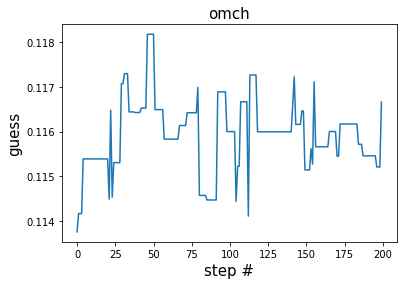

In [17]:
plt.plot(curve_omch[:,2])
plt.title('omch', fontsize='15')
plt.xlabel('step #', fontsize='15')
plt.ylabel('guess', fontsize='15')
burnend = 50
print('OMCH mean: ' +str(np.mean(curve_omch[burnend:,2])) + ' std: ' + str(np.std(curve_omch[burnend:,2])))

In [18]:
# As

stepsize = np.zeros(len(cosmology))
stepsize[2] = 5e-12
result = mcmc(wmap, cosmology, params, stepsize, 200)
curve_As = result[0]


0
(1496.502767002094, 1496.502767002094, 0.6350561145446264, 0.2840610991876915, array([2.0000000e-02, 1.2000000e-01, 2.1322861e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1322861e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), True)
1
(1497.8552229371162, 1497.8552229371162, 0.508531576787464, 0.4898835414077064, array([2.00000000e-02, 1.20000000e-01, 2.13656309e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.13656309e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
2
(1497.3476180576108, 1497.3476180576108, 1.288917140323892, 0.29626494671597403, array([2.00000000e-02, 1.20000000e-01, 2.13516847e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.13516847e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
3
(1496.7168130022387, 1496.7168130022387, 1.3708109892921727, 0.01995880385

(1497.101492673, 1498.2878650430348, 0.5525639061621119, 0.9391389768794254, array([2.00000000e-02, 1.20000000e-01, 2.11534476e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.11213196e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
28
(1496.4206622581635, 1496.4206622581635, 1.4055310563467014, 0.5313153711279678, array([2.00000000e-02, 1.20000000e-01, 2.11782035e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.11782035e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
29
(1496.0512350001381, 1496.0512350001381, 1.2028739226072793, 0.6649415361874174, array([2.00000000e-02, 1.20000000e-01, 2.11963131e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.11963131e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
30
(1497.030130192677, 1497.030130192677, 0.6129649047786595, 0.

(1495.7732481250189, 1495.7732481250189, 5.190476253625516, 0.5132534969273641, array([2.00000000e-02, 1.20000000e-01, 2.12816696e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12816696e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
55
(1495.7732481250189, 1497.5178336475296, 0.41799209368920953, 0.7018835296027823, array([2.00000000e-02, 1.20000000e-01, 2.12816696e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.13565626e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
56
(1495.6294038328647, 1495.6294038328647, 1.0745716811862962, 0.929272510560085, array([2.00000000e-02, 1.20000000e-01, 2.12633437e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12633437e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
57
(1495.5993214470739, 1495.5993214470739, 1.015154880923280

(1496.782097553652, 1496.782097553652, 0.8070503589594462, 0.404938543952321, array([2.0000000e-02, 1.2000000e-01, 2.1164155e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1164155e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), True)
82
(1495.791507215335, 1495.791507215335, 1.6409825350128089, 0.4308016492029635, array([2.00000000e-02, 1.20000000e-01, 2.12143329e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12143329e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
83
(1495.6921786461735, 1495.6921786461735, 1.050918227694239, 0.4819904915345975, array([2.00000000e-02, 1.20000000e-01, 2.12245331e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12245331e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
84
(1496.7534575166915, 1496.7534575166915, 0.5882287152151311, 0.2357105872976

(1495.6784983495045, 1495.6784983495045, 1.1595423211921416, 0.5571656826930238, array([2.0000000e-02, 1.2000000e-01, 2.1271342e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1271342e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), True)
109
(1499.1512234691081, 1499.1512234691081, 0.17616000813964006, 0.10280703256880441, array([2.00000000e-02, 1.20000000e-01, 2.13953353e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.13953353e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
110
(1498.6791767271436, 1498.6791767271436, 1.2662039022500078, 0.837812582147791, array([2.00000000e-02, 1.20000000e-01, 2.13852668e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.13852668e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
111
(1496.641512882591, 1496.641512882591, 2.7699573480817103, 0.60716

(1496.0497877954904, 1496.0497877954904, 0.8294033649283319, 0.11969919296109233, array([2.00000000e-02, 1.20000000e-01, 2.13012427e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.13012427e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
136
(1495.8583669156303, 1495.8583669156303, 1.1004403742645263, 0.054626495460773916, array([2.00000000e-02, 1.20000000e-01, 2.12887302e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12887302e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
137
(1497.3441885882, 1497.3441885882, 0.47572713434937836, 0.024935693380095048, array([2.0000000e-02, 1.2000000e-01, 2.1351584e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1351584e-09, 7.0000000e+01,
       1.0000000e+00, 5.0000000e-02]), True)
138
(1496.5670930529652, 1496.5670930529652, 1.4748374312523054, 0.1187

(1498.4943279484846, 1498.9011823136525, 0.8159296160458731, 0.9571124401439358, array([2.00000000e-02, 1.20000000e-01, 2.11165231e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.11075469e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
163
(1498.4943279484846, 1498.730896173829, 0.8884435986687166, 0.9031410191456894, array([2.00000000e-02, 1.20000000e-01, 2.11165231e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.11112326e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
164
(1498.4943279484846, 1504.1911415886693, 0.05793655073449923, 0.3487886360265816, array([2.00000000e-02, 1.20000000e-01, 2.11165231e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.10210346e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
165
(1498.9139991562217, 1498.9139991562217, 0.810717513

(1497.6049489346287, 1502.7340106650279, 0.07695527537246678, 0.7832201060623112, array([2.00000000e-02, 1.20000000e-01, 2.11386631e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.10412351e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
190
(1496.3389481842485, 1496.3389481842485, 1.8832525752829883, 0.00986403045425821, array([2.00000000e-02, 1.20000000e-01, 2.11817865e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.11817865e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), True)
191
(1496.3389481842485, 1496.4996209755618, 0.9228058662821149, 0.9329771423971923, array([2.00000000e-02, 1.20000000e-01, 2.11817865e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.11749062e-09, 7.00000000e+01,
       1.00000000e+00, 5.00000000e-02]), False)
192
(1495.9105053242722, 1495.9105053242722, 1.23889695

As mean: 2.12427062500671e-09 std: 8.90050172586534e-12


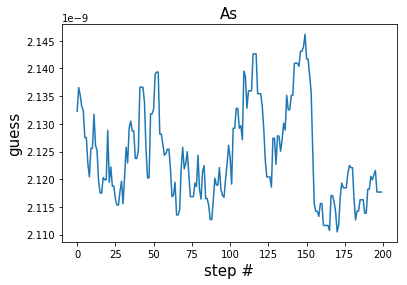

In [19]:
plt.plot(curve_As[:,3])
plt.title('As', fontsize='15')
plt.xlabel('step #', fontsize='15')
plt.ylabel('guess', fontsize='15')
burnend = 25
print('As mean: ' +str(np.mean(curve_As[burnend:,3])) + ' std: ' + str(np.std(curve_As[burnend:,3])))

In [20]:
# H0

stepsize = np.zeros(len(cosmology))
stepsize[3] = 0.5
result = mcmc(wmap, cosmology, params, stepsize, 200)
curve_H0 = result[0]


0
(1495.5946831728297, 1512.7788354391942, 0.00018557041853983934, 0.3686365603891818, array([2.000e-02, 1.200e-01, 2.125e-09, 7.000e+01, 1.000e+00, 5.000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.06052323e+01,
       1.00000000e+00, 5.00000000e-02]), False)
1
(1487.2091043115236, 1487.2091043115236, 66.20721405545211, 0.012691361493362696, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.96850772e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.96850772e+01,
       1.00000000e+00, 5.00000000e-02]), True)
2
(1487.2091043115236, 1496.44269244187, 0.009884434170982441, 0.7965083310149736, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.96850772e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00310898e+01,
       1.00000000e+00, 5.00000000e-02]), False)
3
(1472.7403537611115, 1472.7403537611115, 1386.2745874986626, 0.2426691932211441, array([2

(1425.3867135401088, 1425.3867135401088, 0.9333127423556691, 0.9223894680236134, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.6535097e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.6535097e+01,
       1.0000000e+00, 5.0000000e-02]), True)
28
(1425.1782159604095, 1425.1782159604095, 1.1098765465888945, 0.9387592574162267, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.65190586e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.65190586e+01,
       1.00000000e+00, 5.00000000e-02]), True)
29
(1420.0683717591291, 1420.0683717591291, 12.870297030571143, 0.9867788976101377, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.6092527e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.6092527e+01,
       1.0000000e+00, 5.0000000e-02]), True)
30
(1413.554212063264, 1413.554212063264, 25.97357949069916, 0.8192082097786408, arra

(1407.8313609689133, 1407.8313609689133, 0.6208574732654216, 0.08129031601948167, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.43585904e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.43585904e+01,
       1.00000000e+00, 5.00000000e-02]), True)
55
(1408.0405519103415, 1408.0405519103415, 0.9006888038987129, 0.7977964091986446, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.44231049e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.44231049e+01,
       1.00000000e+00, 5.00000000e-02]), True)
56
(1406.8629648852377, 1406.8629648852377, 1.8018132384438372, 0.34983677838112703, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.3687922e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.3687922e+01,
       1.0000000e+00, 5.0000000e-02]), True)
57
(1407.3333972308512, 1407.3333972308512, 0.7903999681798565, 0.03270

(1407.9713502602485, 1409.4429263270426, 0.4791277415056877, 0.7226095219894078, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.44023118e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.47651694e+01,
       1.00000000e+00, 5.00000000e-02]), False)
82
(1407.9475366695788, 1407.9475366695788, 1.011977963403172, 0.27702622918536735, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.43949398e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.43949398e+01,
       1.00000000e+00, 5.00000000e-02]), True)
83
(1406.9326093194904, 1406.9326093194904, 1.661072827166524, 0.8391179215762652, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.3540603e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.3540603e+01,
       1.0000000e+00, 5.0000000e-02]), True)
84
(1406.9326093194904, 1411.093042091116, 0.12490318199764998, 0.2599764

(1410.5837952162856, 1410.5837952162856, 0.3358251547352497, 0.03274140664561531, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.2503429e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.2503429e+01,
       1.0000000e+00, 5.0000000e-02]), True)
109
(1410.5837952162856, 1417.2719338547397, 0.03529304643726162, 0.86217652506363, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.2503429e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.16934949e+01,
       1.00000000e+00, 5.00000000e-02]), False)
110
(1407.9376811569286, 1407.9376811569286, 3.7548826372903195, 0.4457521955584338, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.3066825e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.3066825e+01,
       1.0000000e+00, 5.0000000e-02]), True)
111
(1406.9086471474125, 1406.9086471474125, 1.672830337549939, 0.9050471496541809, arra

(1407.1111212547105, 1408.3644458483768, 0.5343724042572726, 0.9800765762110244, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.40581425e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.45238368e+01,
       1.00000000e+00, 5.00000000e-02]), False)
136
(1407.1111212547105, 1411.4069444173451, 0.1167276796641509, 0.4726735590891388, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.40581425e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.51089013e+01,
       1.00000000e+00, 5.00000000e-02]), False)
137
(1407.7065007860515, 1407.7065007860515, 0.742531662831416, 0.4583655077437633, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.4316945e+01,
       1.0000000e+00, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 6.4316945e+01,
       1.0000000e+00, 5.0000000e-02]), True)
138
(1406.9709546742133, 1406.9709546742133, 1.444514177829761, 0.4804

(1407.8784369919492, 1407.8784369919492, 0.8731380054326744, 0.3449233771456154, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.43735793e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.43735793e+01,
       1.00000000e+00, 5.00000000e-02]), True)
163
(1406.8629982688922, 1406.8629982688922, 1.6614975953394036, 0.4848862761826396, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.37199304e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.37199304e+01,
       1.00000000e+00, 5.00000000e-02]), True)
164
(1406.96830652041, 1406.96830652041, 0.9487080894328372, 0.053769793617315376, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.35022872e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.35022872e+01,
       1.00000000e+00, 5.00000000e-02]), True)
165
(1407.0226869992507, 1407.0226869992507, 0.97317608745826

(1408.408132588344, 1410.432703302392, 0.3633875595759202, 0.5430200405520158, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.45350617e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.49532275e+01,
       1.00000000e+00, 5.00000000e-02]), False)
190
(1408.408132588344, 1409.0053622906646, 0.7418450751894914, 0.852864316577799, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.45350617e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.46742182e+01,
       1.00000000e+00, 5.00000000e-02]), False)
191
(1408.2485982984376, 1408.2485982984376, 1.0830348481805114, 0.4286368845409825, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.44933466e+01,
       1.00000000e+00, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 6.44933466e+01,
       1.00000000e+00, 5.00000000e-02]), True)
192
(1408.1413498454215, 1408.1413498454215, 1.05508805353135

H0 mean: 63.94338881847319 std: 0.5928934491332282


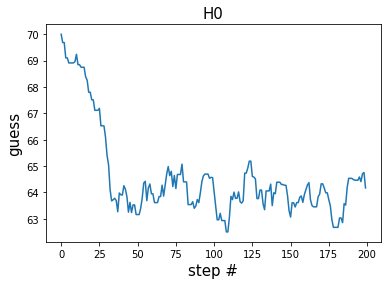

In [22]:
plt.plot(curve_H0[:,4])
plt.title('H0', fontsize='15')
plt.xlabel('step #', fontsize='15')
plt.ylabel('guess', fontsize='15')
burnend = 50
print('H0 mean: ' +str(np.mean(curve_H0[burnend:,4])) + ' std: ' + str(np.std(curve_H0[burnend:,4])))

In [23]:
# ns

stepsize = np.zeros(len(cosmology))
stepsize[4] = 0.05
result = mcmc(wmap, cosmology, params, stepsize, 200)
curve_ns = result[0]


0
(1495.5946831728297, 1967.3258036797465, 3.671881955065928e-103, 0.2598565493743832, array([2.000e-02, 1.200e-01, 2.125e-09, 7.000e+01, 1.000e+00, 5.000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.08106255e+00, 5.00000000e-02]), False)
1
(1428.3818182383056, 1428.3818182383056, 393629988013083.56, 0.9963048274849855, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.73142729e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.73142729e-01, 5.00000000e-02]), True)
2
(1428.3818182383056, 1777.4563526766665, 1.5828069925693033e-76, 0.6226137238443994, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.73142729e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.05508657e+00, 5.00000000e-02]), False)
3
(1428.3818182383056, 1657.4597405002398, 1.804517997513174e-50, 0.9835864651233454, ar

(1414.2969493478722, 1538.3956333811989, 1.1280105368100521e-27, 0.6101288546017763, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.48287019e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.01126488e+00, 5.00000000e-02]), False)
28
(1414.2969493478722, 1442.6883375449013, 6.837359044309664e-07, 0.13991667835555, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.48287019e-01, 5.00000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       9.2725443e-01, 5.0000000e-02]), False)
29
(1414.2969493478722, 1461.216285444269, 6.480307576429379e-11, 0.42266184656856676, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.48287019e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.20183681e-01, 5.00000000e-02]), False)
30
(1414.2969493478722, 1457.675955225834, 3.80512176060

(1413.5749106138637, 1416.846045889225, 0.19484174038940782, 0.6059193769252013, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.50332888e-01, 5.00000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       9.6314951e-01, 5.0000000e-02]), False)
54
(1414.1875435978639, 1414.1875435978639, 0.736153595859085, 0.6978339534284355, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.48542762e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.48542762e-01, 5.00000000e-02]), True)
55
(1414.1875435978639, 1417.1817746948268, 0.2237746973990421, 0.7701150553811005, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.48542762e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.43719224e-01, 5.00000000e-02]), False)
56
(1414.1875435978639, 1442.315611307659, 7.799516901409376e-07, 

(1413.1953601033551, 1446.6004266332454, 5.574192584734038e-08, 0.5164553496553236, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.54712618e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.82776836e-01, 5.00000000e-02]), False)
80
(1413.1953601033551, 1420.693104352098, 0.023544285912525966, 0.16028830545397144, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.54712618e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.40137068e-01, 5.00000000e-02]), False)
81
(1413.1953601033551, 1431.8451415145105, 8.91767051441084e-05, 0.6177202379194738, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.54712618e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.32548585e-01, 5.00000000e-02]), False)
82
(1413.1953601033551, 1618.273257586512, 2.936975

(1416.9700231041568, 1426.0858391104418, 0.01048396844717513, 0.46596680716875305, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.43979108e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.36036246e-01, 5.00000000e-02]), False)
106
(1414.9497175331974, 1414.9497175331974, 2.7460205350325393, 0.21476963575143937, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       9.6024861e-01, 5.0000000e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       9.6024861e-01, 5.0000000e-02]), True)
107
(1413.2721090470038, 1413.2721090470038, 2.313598820329129, 0.1354961361888125, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.51796758e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.51796758e-01, 5.00000000e-02]), True)
108
(1413.2721090470038, 1506.582330710495, 5.4694393794154164e-21, 

(1414.5079782937028, 1495.9029792274437, 2.114950075007788e-18, 0.978650331215482, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.59372085e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.10104328e-01, 5.00000000e-02]), False)
132
(1414.5079782937028, 1447.205258442673, 7.941011574445788e-08, 0.891389177220641, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.59372085e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.25355318e-01, 5.00000000e-02]), False)
133
(1413.510677928854, 1413.510677928854, 1.6464972990673425, 0.3406164094048513, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.50582619e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.50582619e-01, 5.00000000e-02]), True)
134
(1413.368692056943, 1413.368692056943, 1.07357364206

(1413.4239883368778, 1536.276879731663, 2.1029724860548353e-27, 0.42843758476474814, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       9.5095746e-01, 5.0000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.01075371e+00, 5.00000000e-02]), False)
158
(1413.4239883368778, 1426.4332551609805, 0.001496489253103656, 0.26898728160377117, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       9.5095746e-01, 5.0000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.35805567e-01, 5.00000000e-02]), False)
159
(1413.4239883368778, 1483.3853029540337, 6.428261827102442e-16, 0.31100192645262814, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       9.5095746e-01, 5.0000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.13423098e-01, 5.00000000e-02]), False)
160
(1413.4239883368778, 1432.936849282537, 5.792100417105807e-

(1413.2442753605467, 1506.3313088756167, 6.115155483194515e-21, 0.778322869334833, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.55153189e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.07538866e-01, 5.00000000e-02]), False)
184
(1413.2442753605467, 1438.5232777378687, 3.2414130760328763e-06, 0.7857228470523858, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.55153189e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.78936753e-01, 5.00000000e-02]), False)
185
(1413.2442753605467, 1428.451421554743, 0.0004986664627119197, 0.9933992073951619, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.55153189e-01, 5.00000000e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       9.34522857e-01, 5.00000000e-02]), False)
186
(1413.2442753605467, 1423.2667862795136, 0.0

ns mean: 0.9523444800076292 std: 0.00408876907711434


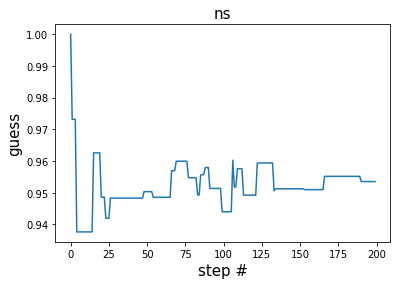

In [24]:
plt.plot(curve_ns[:,5])
plt.title('ns', fontsize='15')
plt.xlabel('step #', fontsize='15')
plt.ylabel('guess', fontsize='15')
burnend = 25
print('ns mean: ' +str(np.mean(curve_ns[burnend:,5])) + ' std: ' + str(np.std(curve_ns[burnend:,5])))

In [25]:
# tau

stepsize = np.zeros(len(cosmology))
stepsize[5] = 5e-5
result = mcmc(wmap, cosmology, params, stepsize, 200)
curve_tau = result[0]


0
(1495.5946831728297, 1495.5946831728297, 1.0, 0.2802032732153804, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.99828023e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.99828023e-02]), True)
1
(1495.5906387447017, 1495.5906387447017, 1.0020242601178413, 0.142405968229521, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00648545e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00648545e-02]), True)
2
(1495.593117856117, 1495.593117856117, 0.998761212224161, 0.8822465144268544, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00103035e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 5.00103035e-02]), True)
3
(1495.5896944812525, 1495.5896944812525, 1.001713153205377, 0.5564183231224341

(1495.641861061671, 1495.641861061671, 1.003565079370258, 0.30584676700741564, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.96875774e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.96875774e-02]), True)
28
(1495.6489785407477, 1495.6489785407477, 0.9964475852702097, 0.37256481205119074, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.96683531e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.96683531e-02]), True)
29
(1495.641861061671, 1495.641861061671, 1.003565079370258, 0.14733398533269348, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.97032193e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.97032193e-02]), True)
30
(1495.6292353527213, 1495.6292353527213, 1.0063328225371002, 

(1495.6090594778343, 1495.6090594778343, 1.0046397740413973, 0.40001133287290036, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.98508185e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.98508185e-02]), True)
55
(1495.6051235095124, 1495.6051235095124, 1.0019699219127312, 0.898396561099994, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.98700051e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.98700051e-02]), True)
56
(1495.5988441665688, 1495.5988441665688, 1.0031446054025503, 0.4804165021585799, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.99365097e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.99365097e-02]), True)
57
(1495.6134908588663, 1495.6134908588663, 0.992703404210138

(1495.6235954698882, 1495.6235954698882, 0.9949604359176355, 0.41274428722582424, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.97858149e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.97858149e-02]), True)
82
(1495.6292353527213, 1495.6292353527213, 0.9971840308835017, 0.9720947649809154, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.97514615e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.97514615e-02]), True)
83
(1495.6353035216462, 1495.6353035216462, 0.9969705137202061, 0.44796898987370215, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.97278229e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.97278229e-02]), True)
84
(1495.6235954698882, 1495.6235954698882, 1.0058711941733

(1495.6715945200217, 1495.6715945200217, 0.995897837844663, 0.06370813584919832, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.95792444e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.95792444e-02]), True)
109
(1495.6803066473626, 1495.6803066473626, 0.9956534102136207, 0.21161216669221095, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.95604168e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.95604168e-02]), True)
110
(1495.6991442804629, 1495.6991442804629, 0.9906254015661397, 0.08476275194786109, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.94925608e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.94925608e-02]), True)
111
(1495.689502616508, 1495.689502616508, 1.004832470883

(1495.689502616508, 1495.689502616508, 0.9954125699756354, 0.55078954944619, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.95185917e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.95185917e-02]), True)
136
(1495.689502616508, 1495.689502616508, 1.0, 0.9643931637491736, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.95336629e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.95336629e-02]), True)
137
(1495.6803066473626, 1495.6803066473626, 1.004608571523742, 0.5586986161995735, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.95504004e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.95504004e-02]), True)
138
(1495.6803066473626, 1495.6803066473626, 1.0, 0.45851849623804986, array([2.0

(1495.6803066473626, 1495.6803066473626, 1.004608571523742, 0.7585593646390854, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       1.0000000e+00, 4.9548252e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       1.0000000e+00, 4.9548252e-02]), True)
163
(1495.6991442804629, 1495.6991442804629, 0.9906254015661397, 0.9076066264048293, array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       1.0000000e+00, 4.9514151e-02]), array([2.0000000e-02, 1.2000000e-01, 2.1250000e-09, 7.0000000e+01,
       1.0000000e+00, 4.9514151e-02]), True)
164
(1495.6991442804629, 1495.6991442804629, 1.0, 0.7813055068138642, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.94951764e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.94951764e-02]), True)
165
(1495.689502616508, 1495.689502616508, 1.0048324708834717, 0.528299319163429, array([2.00000000

(1495.719687870324, 1495.719687870324, 0.989780779788789, 0.8220020910346441, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.94590393e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.94590393e-02]), True)
190
(1495.7305613388512, 1495.7305613388512, 0.9945780180292136, 0.7437427186815345, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.94153093e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.94153093e-02]), True)
191
(1495.753799021103, 1495.753799021103, 0.9884483969471787, 0.5133189296090358, array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.93690874e-02]), array([2.00000000e-02, 1.20000000e-01, 2.12500000e-09, 7.00000000e+01,
       1.00000000e+00, 4.93690874e-02]), True)
192
(1495.7790157122117, 1495.7790157122117, 0.9874708066259058,

tau mean: 0.02 std: 0.0


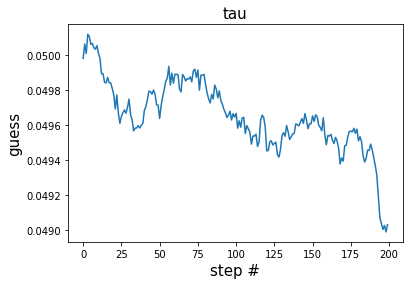

In [26]:
plt.plot(curve_tau[:,6])
plt.title('tau', fontsize='15')
plt.xlabel('step #', fontsize='15')
plt.ylabel('guess', fontsize='15')
burnend = 25
print('tau mean: ' +str(np.mean(curve_tau[burnend:,1])) + ' std: ' + str(np.std(curve_tau[burnend:,1])))

## covariance matrix
- a matrix whose i-j element is the covariance between the ith and jth elements of a vector
- covariance: $cov(x, y) = <(x-<x>)(y-<y>)> = <xy> - <x><y> = \dfrac{ \Sigma(x_i - x_{avg})(y_i - y_{avg})}{n}$

where $n$ is the size of the vector

In [121]:
cov = np.zeros((len(chain[0]), len(chain[0])))
print(len(chain[:,0]))
print(np.mean(chain[20:,0]))

startpoint = 20
means = [np.mean(chain[startpoint:, i]) for i in range(len(chain[0]))]
stds = [np.std(chain[startpoint:, i]) for i in range(len(chain[0]))]
print(means)
print(stds)
var = [s**2 for s in stds]
print(var)
for i in range(len(chain[0])):
    for j in range(len(chain[0])):
        cov[i][j] = chain[i][j]*chain[j][i] - means[i]*means[j]
        if i == j:
            cov[i][j] = stds[i]**2 # along the diagonal, the covariance matrix is just the variance of the parameter
        else:
            #print(chain[startpoint:, i])
            #print(chain[startpoint:, i]-means[i])
            cov[i][j] = np.sum((chain[startpoint:, i]-means[i])*(chain[startpoint:,j]-means[j]))/(len(chain[:,i]))
        
print(cov)

200
1358.9521806905439
[1358.9521806905439, 0.02035938690979766, 0.11839972183231896, 2.10083169835224e-09, 68.49170780663975, 0.9817115118081672, 0.04977170703106937]
[45.95780495460705, 0.00016079012330864765, 0.00035185019710610267, 1.6193160049840352e-11, 0.6325008436959886, 0.008098057541626307, 0.0001325906732722502]
[2112.1198362457044, 2.5853463753610115e-08, 1.237985612036033e-07, 2.622184323997456e-22, 0.40005731727613736, 6.557853594749071e-05, 1.7580286638788605e-08]
[[ 2.11211984e+03 -5.86326166e-03 -3.31817821e-03  6.20084466e-10
   2.52492197e+01  3.30024319e-01  6.85590924e-05]
 [-5.86326166e-03  2.58534638e-08  1.62262313e-08 -1.93746256e-15
  -6.85691795e-05 -9.71033814e-07  4.49134189e-09]
 [-3.31817821e-03  1.62262313e-08  1.23798561e-07 -2.30234591e-15
  -3.39879415e-05 -6.57008940e-07  2.21308102e-08]
 [ 6.20084466e-10 -1.93746256e-15 -2.30234591e-15  2.62218432e-22
   8.13763914e-12  1.06927530e-13 -2.63340665e-16]
 [ 2.52492197e+01 -6.85691795e-05 -3.39879415e-0

## correlation length
- correlation $\rho_{xy} = \dfrac{<(x-x_{avg})(y-y_{avg})>}{\sigma_x \sigma_y} = \dfrac{\Sigma (x_i - x_{avg})(y_i - y_{avg})}{n \sigma_x \sigma_y}$
- so by correlation length, do mean that we:
    - make our chain, based on some stepsize, and acquire a set of parameter lists, each the length of the number of steps we took in the chain
    - take an autocorrelation of each parameter
    - minimize the length at which the correlation drops near zero, by adjusting the stepsize
- autocorrelation as a function of lag: $\rho_{lag} = \dfrac{\Sigma_i^{n-lag} (x_i - x_{avg})(x_{i+lag} - x_{avg})}{\Sigma_i^n (x_i - x_{avg})^2}$

In [122]:
def autocorrelate(lag, x):
    top = 0
    mu = np.mean(x)
    #print(x)
    #print(mu)
    for i in range(len(x) - lag):
        top = top + (x[i]-mu)*(x[i+lag] - mu)
    bottom = np.sum((x-mu)**2)
    #print(top, bottom)
    return top/bottom

def minimize_corr_length(x, zerorange):
    count = 0
    for lag in range(len(x)):
        corr = autocorrelate(lag, x)
        if np.abs(corr) <= zerorange:
            #print(corr)
            count = count + 1
        if count > 10:
            return lag
    return -1
        

Plotting the autocorrelation over a full run. Printing the number of steps it took to get the autocorrelation to be ~0.

199
74
140
198
198
-1
106


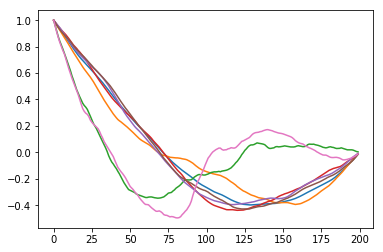

In [123]:


for lag in range(len(chain[:,0])):
    corr.append(autocorrelate(lag, chain[:,3]))

for par in range(len(chain[0])):
    print(minimize_corr_length(chain[:,par], 0.05))
    corr = []

    for lag in range(len(chain[:,0])):
        corr.append(autocorrelate(lag, chain[:,par]))
    
    plt.plot(range(len(chain[:,0])), corr)

## running several chains with various step scales
- scales: 0.0001, 0.001,0.01,0.1 times the order of magnitude of each parameter

- scroll to bottom to see correlation plots for each run.

0
(1495.8628117537728, 1495.8628117537728, 0.8745338386030919, 0.724380582960488, array([1.99978810e-02, 1.19994941e-01, 2.12520878e-09, 6.99877755e+01,
       1.00011017e+00, 4.99965724e-02]), array([1.99978810e-02, 1.19994941e-01, 2.12520878e-09, 6.99877755e+01,
       1.00011017e+00, 4.99965724e-02]), True)
1
(1496.130794898101, 1496.130794898101, 0.8745974355359706, 0.5765219501889585, array([1.99969277e-02, 1.19987506e-01, 2.12526228e-09, 6.99902951e+01,
       1.00015861e+00, 5.00009456e-02]), array([1.99969277e-02, 1.19987506e-01, 2.12526228e-09, 6.99902951e+01,
       1.00015861e+00, 5.00009456e-02]), True)
2
(1495.516456989023, 1495.516456989023, 1.3595706543012387, 0.3302943912844287, array([1.99966519e-02, 1.19975257e-01, 2.12517836e-09, 6.99900765e+01,
       1.00001528e+00, 5.00023226e-02]), array([1.99966519e-02, 1.19975257e-01, 2.12517836e-09, 6.99900765e+01,
       1.00001528e+00, 5.00023226e-02]), True)
3
(1495.4646244088103, 1495.4646244088103, 1.0262550371776615, 0.7

(1493.418997057373, 1493.418997057373, 0.9571572856795881, 0.8316207568080811, array([2.00004234e-02, 1.19938467e-01, 2.12441095e-09, 6.99799421e+01,
       9.99764966e-01, 4.99720600e-02]), array([2.00004234e-02, 1.19938467e-01, 2.12441095e-09, 6.99799421e+01,
       9.99764966e-01, 4.99720600e-02]), True)
28
(1492.8628013018047, 1492.8628013018047, 1.3206154497974518, 0.7981775979548672, array([2.00017807e-02, 1.19947435e-01, 2.12435407e-09, 6.99799564e+01,
       9.99622502e-01, 4.99681409e-02]), array([2.00017807e-02, 1.19947435e-01, 2.12435407e-09, 6.99799564e+01,
       9.99622502e-01, 4.99681409e-02]), True)
29
(1492.4441128013682, 1492.4441128013682, 1.2328693410257716, 0.2226405272572486, array([2.00008261e-02, 1.19947433e-01, 2.12436767e-09, 6.99676927e+01,
       9.99559432e-01, 4.99658275e-02]), array([2.00008261e-02, 1.19947433e-01, 2.12436767e-09, 6.99676927e+01,
       9.99559432e-01, 4.99658275e-02]), True)
30
(1492.4441128013682, 1493.4203707113834, 0.6137737187446921,

(1493.5167497678208, 1493.5167497678208, 1.1559584666617362, 0.8305312185906993, array([2.00067517e-02, 1.20014781e-01, 2.12491305e-09, 6.99722111e+01,
       9.99822465e-01, 4.99436363e-02]), array([2.00067517e-02, 1.20014781e-01, 2.12491305e-09, 6.99722111e+01,
       9.99822465e-01, 4.99436363e-02]), True)
55
(1493.8668691367543, 1493.8668691367543, 0.839406919719697, 0.21506542775909465, array([2.00065741e-02, 1.20016909e-01, 2.12495219e-09, 6.99768927e+01,
       9.99873087e-01, 4.99448625e-02]), array([2.00065741e-02, 1.20016909e-01, 2.12495219e-09, 6.99768927e+01,
       9.99873087e-01, 4.99448625e-02]), True)
56
(1493.0964972860681, 1493.0964972860681, 1.4698875853906135, 0.3404170360446024, array([2.00101316e-02, 1.20023357e-01, 2.12473237e-09, 6.99723981e+01,
       9.99799001e-01, 4.99483353e-02]), array([2.00101316e-02, 1.20023357e-01, 2.12473237e-09, 6.99723981e+01,
       9.99799001e-01, 4.99483353e-02]), True)
57
(1494.0243231368474, 1494.0243231368474, 0.628818306192313

(1496.2079665224219, 1496.2079665224219, 0.992667771567648, 0.04063575828516708, array([1.99864142e-02, 1.20055209e-01, 2.12522354e-09, 6.99431789e+01,
       9.99896957e-01, 4.99857044e-02]), array([1.99864142e-02, 1.20055209e-01, 2.12522354e-09, 6.99431789e+01,
       9.99896957e-01, 4.99857044e-02]), True)
82
(1497.3622356304945, 1497.3622356304945, 0.5615050258783424, 0.1730283892970902, array([1.99871455e-02, 1.20070540e-01, 2.12523631e-09, 6.99567646e+01,
       1.00009709e+00, 4.99887235e-02]), array([1.99871455e-02, 1.20070540e-01, 2.12523631e-09, 6.99567646e+01,
       1.00009709e+00, 4.99887235e-02]), True)
83
(1497.2964498195734, 1497.2964498195734, 1.0334398575491517, 0.5936666750269705, array([1.99849960e-02, 1.20078079e-01, 2.12502587e-09, 6.99586285e+01,
       9.99951892e-01, 4.99875515e-02]), array([1.99849960e-02, 1.20078079e-01, 2.12502587e-09, 6.99586285e+01,
       9.99951892e-01, 4.99875515e-02]), True)
84
(1496.9450432919677, 1496.9450432919677, 1.192084271609058

(1495.9894165765936, 1495.9894165765936, 0.9802029907019959, 0.8162801798240736, array([1.99876879e-02, 1.20189970e-01, 2.12514578e-09, 6.99801988e+01,
       9.99091930e-01, 4.99665385e-02]), array([1.99876879e-02, 1.20189970e-01, 2.12514578e-09, 6.99801988e+01,
       9.99091930e-01, 4.99665385e-02]), True)
109
(1496.1099270984712, 1496.1099270984712, 0.9415241685644937, 0.5234079640239799, array([1.99852676e-02, 1.20196653e-01, 2.12527402e-09, 6.99788021e+01,
       9.99019230e-01, 4.99655278e-02]), array([1.99852676e-02, 1.20196653e-01, 2.12527402e-09, 6.99788021e+01,
       9.99019230e-01, 4.99655278e-02]), True)
110
(1495.4419074887, 1495.4419074887, 1.396556836587348, 0.09726337823859965, array([1.99879328e-02, 1.20184556e-01, 2.12513795e-09, 6.99801363e+01,
       9.98961924e-01, 4.99574536e-02]), array([1.99879328e-02, 1.20184556e-01, 2.12513795e-09, 6.99801363e+01,
       9.98961924e-01, 4.99574536e-02]), True)
111
(1495.1764941507583, 1495.1764941507583, 1.141914990099899, 0

(1495.8090019546812, 1495.8090019546812, 0.8635490887502785, 0.6075395174337488, array([1.99871950e-02, 1.20192830e-01, 2.12517377e-09, 6.99721826e+01,
       9.99073908e-01, 4.99796253e-02]), array([1.99871950e-02, 1.20192830e-01, 2.12517377e-09, 6.99721826e+01,
       9.99073908e-01, 4.99796253e-02]), True)
136
(1496.6157124452116, 1496.6157124452116, 0.6680747267798491, 0.3105780911374787, array([1.99831108e-02, 1.20183119e-01, 2.12520001e-09, 6.99807445e+01,
       9.99116989e-01, 4.99830313e-02]), array([1.99831108e-02, 1.20183119e-01, 2.12520001e-09, 6.99807445e+01,
       9.99116989e-01, 4.99830313e-02]), True)
137
(1496.1416965587734, 1496.1416965587734, 1.267451185377706, 0.4395292456958132, array([1.99839559e-02, 1.20177363e-01, 2.12496198e-09, 6.99823039e+01,
       9.99019655e-01, 4.99837206e-02]), array([1.99839559e-02, 1.20177363e-01, 2.12496198e-09, 6.99823039e+01,
       9.99019655e-01, 4.99837206e-02]), True)
138
(1496.8789114716083, 1496.8789114716083, 0.6916968783360

(1494.408962944528, 1494.408962944528, 0.9775915766192311, 0.04062322317840372, array([1.99827376e-02, 1.20158976e-01, 2.12520113e-09, 6.99998228e+01,
       9.98387996e-01, 4.99714734e-02]), array([1.99827376e-02, 1.20158976e-01, 2.12520113e-09, 6.99998228e+01,
       9.98387996e-01, 4.99714734e-02]), True)
163
(1494.408962944528, 1494.8734223912204, 0.7927639859912615, 0.9128646435311694, array([1.99827376e-02, 1.20158976e-01, 2.12520113e-09, 6.99998228e+01,
       9.98387996e-01, 4.99714734e-02]), array([1.99798943e-02, 1.20160220e-01, 2.12491992e-09, 7.00015502e+01,
       9.98394859e-01, 4.99789719e-02]), False)
164
(1494.6265496338556, 1494.6265496338556, 0.8969157507735318, 0.8729642523124614, array([1.99853028e-02, 1.20154024e-01, 2.12516637e-09, 7.00039806e+01,
       9.98537960e-01, 4.99700141e-02]), array([1.99853028e-02, 1.20154024e-01, 2.12516637e-09, 7.00039806e+01,
       9.98537960e-01, 4.99700141e-02]), True)
165
(1494.3537501015858, 1494.3537501015858, 1.1461399899768

(1491.503734820302, 1491.9286945224537, 0.8085766081060745, 0.9216507138565433, array([1.99976187e-02, 1.20191531e-01, 2.12563350e-09, 6.99974114e+01,
       9.98009258e-01, 4.99854790e-02]), array([1.99965504e-02, 1.20185989e-01, 2.12587218e-09, 7.00031195e+01,
       9.98064975e-01, 4.99893990e-02]), False)
190
(1492.2907505069147, 1492.2907505069147, 0.6746860257869374, 0.540627000861006, array([1.99962300e-02, 1.20205838e-01, 2.12595438e-09, 7.00013924e+01,
       9.98100676e-01, 4.99856972e-02]), array([1.99962300e-02, 1.20205838e-01, 2.12595438e-09, 7.00013924e+01,
       9.98100676e-01, 4.99856972e-02]), True)
191
(1492.6700735933566, 1492.6700735933566, 0.827239071238908, 0.5834417892656817, array([1.99968655e-02, 1.20203925e-01, 2.12633937e-09, 7.00006890e+01,
       9.98248355e-01, 4.99870049e-02]), array([1.99968655e-02, 1.20203925e-01, 2.12633937e-09, 7.00006890e+01,
       9.98248355e-01, 4.99870049e-02]), True)
192
(1492.6218097083108, 1492.6218097083108, 1.02442547425558

(1491.5491315194731, 1491.5491315194731, 1.3690815653291097, 0.21433689078593154, array([1.99995241e-02, 1.20160512e-01, 2.12647918e-09, 6.99728516e+01,
       9.98404955e-01, 4.99817141e-02]), array([1.99995241e-02, 1.20160512e-01, 2.12647918e-09, 6.99728516e+01,
       9.98404955e-01, 4.99817141e-02]), True)
217
(1491.5904064872625, 1491.5904064872625, 0.9795740115659813, 0.4892575353900884, array([2.00018298e-02, 1.20178682e-01, 2.12657050e-09, 6.99733730e+01,
       9.98438006e-01, 4.99890796e-02]), array([2.00018298e-02, 1.20178682e-01, 2.12657050e-09, 6.99733730e+01,
       9.98438006e-01, 4.99890796e-02]), True)
218
(1492.0155029604257, 1492.0155029604257, 0.8085213150764291, 0.2604998522065629, array([2.00004871e-02, 1.20177434e-01, 2.12656587e-09, 6.99715214e+01,
       9.98531485e-01, 4.99886995e-02]), array([2.00004871e-02, 1.20177434e-01, 2.12656587e-09, 6.99715214e+01,
       9.98531485e-01, 4.99886995e-02]), True)
219
(1491.997737078161, 1491.997737078161, 1.0089225115343

(1485.9770105445014, 1485.9770105445014, 1.2441705493583737, 0.18068575816804677, array([2.00099893e-02, 1.20209859e-01, 2.12757347e-09, 6.99087229e+01,
       9.97454443e-01, 4.99835504e-02]), array([2.00099893e-02, 1.20209859e-01, 2.12757347e-09, 6.99087229e+01,
       9.97454443e-01, 4.99835504e-02]), True)
244
(1485.3792728610297, 1485.3792728610297, 1.3483327668898462, 0.6245515490234358, array([2.00102635e-02, 1.20224160e-01, 2.12753859e-09, 6.98997508e+01,
       9.97305543e-01, 4.99901662e-02]), array([2.00102635e-02, 1.20224160e-01, 2.12753859e-09, 6.98997508e+01,
       9.97305543e-01, 4.99901662e-02]), True)
245
(1485.1672479311528, 1485.1672479311528, 1.1118357353841422, 0.27779721893642706, array([2.00109894e-02, 1.20237422e-01, 2.12742859e-09, 6.99099474e+01,
       9.97140071e-01, 4.99906869e-02]), array([2.00109894e-02, 1.20237422e-01, 2.12742859e-09, 6.99099474e+01,
       9.97140071e-01, 4.99906869e-02]), True)
246
(1485.3540379664723, 1485.3540379664723, 0.9108336338

(1484.870643493103, 1484.870643493103, 1.1042983339862473, 0.7682849156320768, array([2.00162166e-02, 1.20246689e-01, 2.12507370e-09, 6.98790419e+01,
       9.97523631e-01, 4.99733859e-02]), array([2.00162166e-02, 1.20246689e-01, 2.12507370e-09, 6.98790419e+01,
       9.97523631e-01, 4.99733859e-02]), True)
271
(1484.870643493103, 1485.8835911405995, 0.6026167697101459, 0.7553681061357835, array([2.00162166e-02, 1.20246689e-01, 2.12507370e-09, 6.98790419e+01,
       9.97523631e-01, 4.99733859e-02]), array([2.00129391e-02, 1.20258955e-01, 2.12528827e-09, 6.98764253e+01,
       9.97674538e-01, 4.99729311e-02]), False)
272
(1484.3385065836678, 1484.3385065836678, 1.304824377013987, 0.8655907811862642, array([2.00170434e-02, 1.20244819e-01, 2.12505931e-09, 6.98696639e+01,
       9.97479397e-01, 4.99748676e-02]), array([2.00170434e-02, 1.20244819e-01, 2.12505931e-09, 6.98696639e+01,
       9.97479397e-01, 4.99748676e-02]), True)
273
(1485.002624385427, 1485.002624385427, 0.7174450634646039,

(1483.8988611901664, 1483.8988611901664, 0.7331871100051179, 0.24752720468608957, array([2.00091085e-02, 1.20244331e-01, 2.12495703e-09, 6.98539827e+01,
       9.97161878e-01, 4.99750895e-02]), array([2.00091085e-02, 1.20244331e-01, 2.12495703e-09, 6.98539827e+01,
       9.97161878e-01, 4.99750895e-02]), True)
298
(1483.8988611901664, 1484.8063120301895, 0.635257138198446, 0.926836354643986, array([2.00091085e-02, 1.20244331e-01, 2.12495703e-09, 6.98539827e+01,
       9.97161878e-01, 4.99750895e-02]), array([2.00075968e-02, 1.20257573e-01, 2.12467907e-09, 6.98467568e+01,
       9.97386914e-01, 4.99762234e-02]), False)
299
(1484.2257736264378, 1484.2257736264378, 0.8492036779078804, 0.7177049368493366, array([2.00063008e-02, 1.20240886e-01, 2.12509015e-09, 6.98536560e+01,
       9.97163269e-01, 4.99719982e-02]), array([2.00063008e-02, 1.20240886e-01, 2.12509015e-09, 6.98536560e+01,
       9.97163269e-01, 4.99719982e-02]), True)
300
(1484.2257736264378, 1484.7956310333568, 0.752067872245

(1486.060474664616, 1486.060474664616, 0.5903626614493523, 0.08718689203299368, array([1.99991340e-02, 1.20223752e-01, 2.12631288e-09, 6.99034314e+01,
       9.97068299e-01, 4.99862560e-02]), array([1.99991340e-02, 1.20223752e-01, 2.12631288e-09, 6.99034314e+01,
       9.97068299e-01, 4.99862560e-02]), True)
325
(1485.6374440894206, 1485.6374440894206, 1.2355488540582176, 0.9832528857357026, array([1.99979261e-02, 1.20203983e-01, 2.12645830e-09, 6.98899694e+01,
       9.97070015e-01, 4.99899919e-02]), array([1.99979261e-02, 1.20203983e-01, 2.12645830e-09, 6.98899694e+01,
       9.97070015e-01, 4.99899919e-02]), True)
326
(1485.727743163597, 1485.727743163597, 0.9558545354414388, 0.25936653990787906, array([1.99958953e-02, 1.20192024e-01, 2.12657649e-09, 6.98902600e+01,
       9.97052245e-01, 4.99929562e-02]), array([1.99958953e-02, 1.20192024e-01, 2.12657649e-09, 6.98902600e+01,
       9.97052245e-01, 4.99929562e-02]), True)
327
(1485.5937699702947, 1485.5937699702947, 1.06928114613037

(1489.7150677612487, 1489.7150677612487, 1.0924585049987352, 0.6945791530865186, array([1.99925840e-02, 1.20202213e-01, 2.12673937e-09, 6.99465534e+01,
       9.97635533e-01, 5.00253930e-02]), array([1.99925840e-02, 1.20202213e-01, 2.12673937e-09, 6.99465534e+01,
       9.97635533e-01, 5.00253930e-02]), True)
352
(1490.667363754451, 1490.667363754451, 0.6211715441671489, 0.3960854816133874, array([1.99882266e-02, 1.20197336e-01, 2.12666529e-09, 6.99457525e+01,
       9.97776673e-01, 5.00322074e-02]), array([1.99882266e-02, 1.20197336e-01, 2.12666529e-09, 6.99457525e+01,
       9.97776673e-01, 5.00322074e-02]), True)
353
(1490.9504010861247, 1490.9504010861247, 0.8680389727597982, 0.06566875791238269, array([1.99882790e-02, 1.20212992e-01, 2.12691437e-09, 6.99365745e+01,
       9.97878381e-01, 5.00390383e-02]), array([1.99882790e-02, 1.20212992e-01, 2.12691437e-09, 6.99365745e+01,
       9.97878381e-01, 5.00390383e-02]), True)
354
(1490.9504010861247, 1491.2686442411427, 0.8528926601004

(1486.3209473058896, 1486.3209473058896, 0.9977680863520112, 0.9293723920200037, array([2.00000259e-02, 1.20188105e-01, 2.12778586e-09, 6.99007147e+01,
       9.97301025e-01, 5.00374933e-02]), array([2.00000259e-02, 1.20188105e-01, 2.12778586e-09, 6.99007147e+01,
       9.97301025e-01, 5.00374933e-02]), True)
379
(1486.166717671293, 1486.166717671293, 1.0801660910251867, 0.7001502748052267, array([1.99997628e-02, 1.20201850e-01, 2.12732259e-09, 6.98877958e+01,
       9.97317085e-01, 5.00446880e-02]), array([1.99997628e-02, 1.20201850e-01, 2.12732259e-09, 6.98877958e+01,
       9.97317085e-01, 5.00446880e-02]), True)
380
(1486.310078019726, 1486.310078019726, 0.9308285511804665, 0.33695751233473903, array([2.00011053e-02, 1.20206982e-01, 2.12746866e-09, 6.98925696e+01,
       9.97353072e-01, 5.00446203e-02]), array([2.00011053e-02, 1.20206982e-01, 2.12746866e-09, 6.98925696e+01,
       9.97353072e-01, 5.00446203e-02]), True)
381
(1486.337786137844, 1486.337786137844, 0.9862414667682412,

(1484.1506860346753, 1484.1506860346753, 0.8271762001897672, 0.1257587951091046, array([2.00177008e-02, 1.20148604e-01, 2.12761556e-09, 6.98812408e+01,
       9.97656963e-01, 5.00444265e-02]), array([2.00177008e-02, 1.20148604e-01, 2.12761556e-09, 6.98812408e+01,
       9.97656963e-01, 5.00444265e-02]), True)
406
(1483.8707656806937, 1483.8707656806937, 1.150227992405264, 0.8973425466110918, array([2.00178629e-02, 1.20152270e-01, 2.12762636e-09, 6.98812533e+01,
       9.97563433e-01, 5.00421444e-02]), array([2.00178629e-02, 1.20152270e-01, 2.12762636e-09, 6.98812533e+01,
       9.97563433e-01, 5.00421444e-02]), True)
407
(1483.6931548170144, 1483.6931548170144, 1.0928679983228344, 0.45311886853355543, array([2.00189099e-02, 1.20156448e-01, 2.12756344e-09, 6.98812923e+01,
       9.97538572e-01, 5.00383781e-02]), array([2.00189099e-02, 1.20156448e-01, 2.12756344e-09, 6.98812923e+01,
       9.97538572e-01, 5.00383781e-02]), True)
408
(1484.6812513817702, 1484.6812513817702, 0.610151322822

(1483.2209881039023, 1483.2209881039023, 1.0042792472728954, 0.7813473358233778, array([2.00230943e-02, 1.20152370e-01, 2.12770903e-09, 6.98466372e+01,
       9.97855192e-01, 5.00262084e-02]), array([2.00230943e-02, 1.20152370e-01, 2.12770903e-09, 6.98466372e+01,
       9.97855192e-01, 5.00262084e-02]), True)
433
(1482.7928534108974, 1482.7928534108974, 1.23870607450612, 0.8895456452186955, array([2.00267392e-02, 1.20141509e-01, 2.12760052e-09, 6.98516639e+01,
       9.97872737e-01, 5.00265093e-02]), array([2.00267392e-02, 1.20141509e-01, 2.12760052e-09, 6.98516639e+01,
       9.97872737e-01, 5.00265093e-02]), True)
434
(1481.9390116419493, 1481.9390116419493, 1.5325314098990919, 0.9228046932835333, array([2.00305455e-02, 1.20144061e-01, 2.12778847e-09, 6.98594269e+01,
       9.97680007e-01, 5.00238282e-02]), array([2.00305455e-02, 1.20144061e-01, 2.12778847e-09, 6.98594269e+01,
       9.97680007e-01, 5.00238282e-02]), True)
435
(1482.237251179115, 1482.237251179115, 0.8614659321661758

(1482.8060313976248, 1482.8060313976248, 0.8197208040268843, 0.10735686106776932, array([2.00319059e-02, 1.20152481e-01, 2.12741980e-09, 6.98790111e+01,
       9.97825385e-01, 5.00176296e-02]), array([2.00319059e-02, 1.20152481e-01, 2.12741980e-09, 6.98790111e+01,
       9.97825385e-01, 5.00176296e-02]), True)
460
(1482.6816377343582, 1482.6816377343582, 1.0641717867858371, 0.5584102326151114, array([2.00320657e-02, 1.20136272e-01, 2.12758636e-09, 6.98765696e+01,
       9.97865712e-01, 5.00166275e-02]), array([2.00320657e-02, 1.20136272e-01, 2.12758636e-09, 6.98765696e+01,
       9.97865712e-01, 5.00166275e-02]), True)
461
(1482.3364578072662, 1482.3364578072662, 1.188378726570316, 0.5657108113039419, array([2.00346233e-02, 1.20138294e-01, 2.12766580e-09, 6.98832601e+01,
       9.97798384e-01, 5.00180614e-02]), array([2.00346233e-02, 1.20138294e-01, 2.12766580e-09, 6.98832601e+01,
       9.97798384e-01, 5.00180614e-02]), True)
462
(1482.3364578072662, 1482.7105963998347, 0.829386261007

(1478.4279590824253, 1478.4279590824253, 1.260179828605814, 0.6845258540476241, array([2.00394682e-02, 1.20083415e-01, 2.12726949e-09, 6.98611185e+01,
       9.97169848e-01, 5.00344202e-02]), array([2.00394682e-02, 1.20083415e-01, 2.12726949e-09, 6.98611185e+01,
       9.97169848e-01, 5.00344202e-02]), True)
487
(1477.496073766791, 1477.496073766791, 1.593515621064571, 0.724591078066864, array([2.00394151e-02, 1.20073086e-01, 2.12737084e-09, 6.98595738e+01,
       9.96918243e-01, 5.00363392e-02]), array([2.00394151e-02, 1.20073086e-01, 2.12737084e-09, 6.98595738e+01,
       9.96918243e-01, 5.00363392e-02]), True)
488
(1477.401121246874, 1477.401121246874, 1.0486213065123935, 0.0895698658963856, array([2.00386605e-02, 1.20062579e-01, 2.12726015e-09, 6.98451083e+01,
       9.97014009e-01, 5.00361656e-02]), array([2.00386605e-02, 1.20062579e-01, 2.12726015e-09, 6.98451083e+01,
       9.97014009e-01, 5.00361656e-02]), True)
489
(1477.7746979816275, 1477.7746979816275, 0.8296192923152232, 0

(1478.5374804133644, 1478.5374804133644, 1.2059805508258523, 0.7780132988503274, array([2.00722990e-02, 1.19759839e-01, 2.12638766e-09, 6.95412477e+01,
       1.00207530e+00, 4.99468398e-02]), array([2.00722990e-02, 1.19759839e-01, 2.12638766e-09, 6.95412477e+01,
       1.00207530e+00, 4.99468398e-02]), True)
14
(1471.6540658315496, 1471.6540658315496, 31.240248856829236, 0.28280544516978534, array([2.00769056e-02, 1.19631299e-01, 2.12339710e-09, 6.95288306e+01,
       1.00079255e+00, 5.00216336e-02]), array([2.00769056e-02, 1.19631299e-01, 2.12339710e-09, 6.95288306e+01,
       1.00079255e+00, 5.00216336e-02]), True)
15
(1462.4519252041528, 1462.4519252041528, 99.59085207127222, 0.9370572042097901, array([2.00848833e-02, 1.19546672e-01, 2.12170032e-09, 6.94575575e+01,
       9.99154509e-01, 5.00286472e-02]), array([2.00848833e-02, 1.19546672e-01, 2.12170032e-09, 6.94575575e+01,
       9.99154509e-01, 5.00286472e-02]), True)
16
(1457.8249396026506, 1457.8249396026506, 10.10967413688772

(1421.7590016485542, 1421.7590016485542, 12.816812546048386, 0.32722699477593986, array([2.01620122e-02, 1.20027643e-01, 2.12327856e-09, 6.91122485e+01,
       9.89755620e-01, 5.02744295e-02]), array([2.01620122e-02, 1.20027643e-01, 2.12327856e-09, 6.91122485e+01,
       9.89755620e-01, 5.02744295e-02]), True)
41
(1417.2662942807588, 1417.2662942807588, 9.453203548483604, 0.42527837672540103, array([2.01872839e-02, 1.19997924e-01, 2.12335027e-09, 6.90526341e+01,
       9.89730028e-01, 5.02320226e-02]), array([2.01872839e-02, 1.19997924e-01, 2.12335027e-09, 6.90526341e+01,
       9.89730028e-01, 5.02320226e-02]), True)
42
(1416.510924722123, 1416.510924722123, 1.4589029939899634, 0.7549446142688254, array([2.01743443e-02, 1.20244498e-01, 2.12185242e-09, 6.90278058e+01,
       9.88425053e-01, 5.02265379e-02]), array([2.01743443e-02, 1.20244498e-01, 2.12185242e-09, 6.90278058e+01,
       9.88425053e-01, 5.02265379e-02]), True)
43
(1416.9238937344971, 1416.9238937344971, 0.8134388646289378

(1398.1294882336085, 1398.1294882336085, 6.999783636415008, 0.82884488115363, array([2.01789246e-02, 1.20283396e-01, 2.11980330e-09, 6.87128864e+01,
       9.84213120e-01, 5.02218071e-02]), array([2.01789246e-02, 1.20283396e-01, 2.11980330e-09, 6.87128864e+01,
       9.84213120e-01, 5.02218071e-02]), True)
68
(1398.1294882336085, 1404.3116285864699, 0.045453285332360656, 0.4373852162929389, array([2.01789246e-02, 1.20283396e-01, 2.11980330e-09, 6.87128864e+01,
       9.84213120e-01, 5.02218071e-02]), array([2.01596202e-02, 1.20268248e-01, 2.12342256e-09, 6.88544049e+01,
       9.84218905e-01, 5.02159174e-02]), False)
69
(1398.1294882336085, 1401.3383772437062, 0.20100117904417814, 0.6735426434732732, array([2.01789246e-02, 1.20283396e-01, 2.11980330e-09, 6.87128864e+01,
       9.84213120e-01, 5.02218071e-02]), array([2.01907874e-02, 1.20371539e-01, 2.11796800e-09, 6.87000463e+01,
       9.85889007e-01, 5.01106794e-02]), False)
70
(1398.1294882336085, 1399.4198355474023, 0.5245714387482

(1367.5222818337413, 1367.5222818337413, 4.094414809818944, 0.5016779422774067, array([2.02992621e-02, 1.20756849e-01, 2.11283649e-09, 6.80887340e+01,
       9.80714591e-01, 5.00098122e-02]), array([2.02992621e-02, 1.20756849e-01, 2.11283649e-09, 6.80887340e+01,
       9.80714591e-01, 5.00098122e-02]), True)
95
(1367.4822244179147, 1367.4822244179147, 1.020230628298772, 0.5080135022376994, array([2.03106523e-02, 1.20646392e-01, 2.11525051e-09, 6.81458803e+01,
       9.80998251e-01, 5.00091682e-02]), array([2.03106523e-02, 1.20646392e-01, 2.11525051e-09, 6.81458803e+01,
       9.80998251e-01, 5.00091682e-02]), True)
96
(1359.0547921019254, 1359.0547921019254, 67.6073130218684, 0.13673297497040116, array([2.03343408e-02, 1.20631573e-01, 2.11562058e-09, 6.80786534e+01,
       9.78811587e-01, 4.99714448e-02]), array([2.03343408e-02, 1.20631573e-01, 2.11562058e-09, 6.80786534e+01,
       9.78811587e-01, 4.99714448e-02]), True)
97
(1359.0547921019254, 1359.4315414035354, 0.8283043242118104, 

(1334.5811538251753, 1334.5811538251753, 0.7732921291011255, 0.49448556750538775, array([2.03454348e-02, 1.20029824e-01, 2.10463318e-09, 6.77859261e+01,
       9.72871571e-01, 5.02912511e-02]), array([2.03454348e-02, 1.20029824e-01, 2.10463318e-09, 6.77859261e+01,
       9.72871571e-01, 5.02912511e-02]), True)
122
(1334.5811538251753, 1335.6693365613191, 0.5803688855321006, 0.8160301901648723, array([2.03454348e-02, 1.20029824e-01, 2.10463318e-09, 6.77859261e+01,
       9.72871571e-01, 5.02912511e-02]), array([2.03574966e-02, 1.20099243e-01, 2.10625263e-09, 6.79003583e+01,
       9.72572721e-01, 5.03107102e-02]), False)
123
(1334.3121695566906, 1334.3121695566906, 1.1439556608890165, 0.3936728897687889, array([2.03429872e-02, 1.20035131e-01, 2.10674563e-09, 6.77020690e+01,
       9.73105075e-01, 5.03092365e-02]), array([2.03429872e-02, 1.20035131e-01, 2.10674563e-09, 6.77020690e+01,
       9.73105075e-01, 5.03092365e-02]), True)
124
(1334.4605773328503, 1334.4605773328503, 0.9284823680

(1307.8736032928443, 1307.8736032928443, 2.872548243803379, 0.1604491478649307, array([2.04696828e-02, 1.19588435e-01, 2.11107162e-09, 6.72590537e+01,
       9.63612121e-01, 5.02735861e-02]), array([2.04696828e-02, 1.19588435e-01, 2.11107162e-09, 6.72590537e+01,
       9.63612121e-01, 5.02735861e-02]), True)
148
(1307.8736032928443, 1311.2702320386986, 0.18299172002540637, 0.6415731565633583, array([2.04696828e-02, 1.19588435e-01, 2.11107162e-09, 6.72590537e+01,
       9.63612121e-01, 5.02735861e-02]), array([2.04694860e-02, 1.19562958e-01, 2.11470669e-09, 6.72454531e+01,
       9.63695707e-01, 5.02716396e-02]), False)
149
(1305.5032165402465, 1305.5032165402465, 3.2713193559350033, 0.8605761669257744, array([2.04713014e-02, 1.19613320e-01, 2.10952735e-09, 6.72684583e+01,
       9.62740551e-01, 5.03677780e-02]), array([2.04713014e-02, 1.19613320e-01, 2.10952735e-09, 6.72684583e+01,
       9.62740551e-01, 5.03677780e-02]), True)
150
(1305.5032165402465, 1306.8388178478397, 0.51283524061

(1298.595039834015, 1298.595039834015, 23.006249369477956, 0.5630946709336531, array([2.05808060e-02, 1.19714923e-01, 2.11211380e-09, 6.72526382e+01,
       9.58602997e-01, 5.03190587e-02]), array([2.05808060e-02, 1.19714923e-01, 2.11211380e-09, 6.72526382e+01,
       9.58602997e-01, 5.03190587e-02]), True)
174
(1298.595039834015, 1302.0232291793977, 0.1801267205570178, 0.8399695192306319, array([2.05808060e-02, 1.19714923e-01, 2.11211380e-09, 6.72526382e+01,
       9.58602997e-01, 5.03190587e-02]), array([2.05791841e-02, 1.19521482e-01, 2.11498006e-09, 6.72083132e+01,
       9.59226765e-01, 5.03785822e-02]), False)
175
(1296.4289455775538, 1296.4289455775538, 2.953666051812546, 0.8964586603213275, array([2.06108425e-02, 1.19597702e-01, 2.11118328e-09, 6.72271560e+01,
       9.58718669e-01, 5.02133233e-02]), array([2.06108425e-02, 1.19597702e-01, 2.11118328e-09, 6.72271560e+01,
       9.58718669e-01, 5.02133233e-02]), True)
176
(1300.2869366152177, 1300.2869366152177, 0.145294070366094

(1291.4686016687, 1291.4686016687, 0.7513511810059667, 0.40163605937413105, array([2.06960441e-02, 1.19485417e-01, 2.11094342e-09, 6.71351692e+01,
       9.60551465e-01, 5.01409940e-02]), array([2.06960441e-02, 1.19485417e-01, 2.11094342e-09, 6.71351692e+01,
       9.60551465e-01, 5.01409940e-02]), True)
200
(1291.4686016687, 1293.1965158081339, 0.4214909091115741, 0.6349595346961938, array([2.06960441e-02, 1.19485417e-01, 2.11094342e-09, 6.71351692e+01,
       9.60551465e-01, 5.01409940e-02]), array([2.06932122e-02, 1.19581550e-01, 2.11336638e-09, 6.70972548e+01,
       9.59736866e-01, 5.01722590e-02]), False)
201
(1292.7602989858601, 1292.7602989858601, 0.5242174716217809, 0.28664628843995976, array([2.06884399e-02, 1.19454672e-01, 2.11171327e-09, 6.71289469e+01,
       9.61735217e-01, 5.02044647e-02]), array([2.06884399e-02, 1.19454672e-01, 2.11171327e-09, 6.71289469e+01,
       9.61735217e-01, 5.02044647e-02]), True)
202
(1290.134356745561, 1290.134356745561, 3.7172015740430746, 0.

(1283.386889448267, 1283.386889448267, 1.4266939826571279, 0.3747089671833379, array([2.06215704e-02, 1.20488697e-01, 2.10091948e-09, 6.67577566e+01,
       9.59693363e-01, 4.98160712e-02]), array([2.06215704e-02, 1.20488697e-01, 2.10091948e-09, 6.67577566e+01,
       9.59693363e-01, 4.98160712e-02]), True)
227
(1283.386889448267, 1286.9695371811445, 0.16673928294633988, 0.6013704299761216, array([2.06215704e-02, 1.20488697e-01, 2.10091948e-09, 6.67577566e+01,
       9.59693363e-01, 4.98160712e-02]), array([2.05837043e-02, 1.20459878e-01, 2.10150431e-09, 6.67700064e+01,
       9.60601571e-01, 4.97625560e-02]), False)
228
(1281.7933235822793, 1281.7933235822793, 2.2183927185009744, 0.4809065705260456, array([2.06477257e-02, 1.20372415e-01, 2.10051116e-09, 6.67561015e+01,
       9.60118401e-01, 4.98419259e-02]), array([2.06477257e-02, 1.20372415e-01, 2.10051116e-09, 6.67561015e+01,
       9.60118401e-01, 4.98419259e-02]), True)
229
(1281.2973340105657, 1281.2973340105657, 1.2814532504958

(1275.9301709003112, 1279.07815624196, 0.20721618249034407, 0.3102147856765257, array([2.06503160e-02, 1.20051479e-01, 2.09538418e-09, 6.67661589e+01,
       9.56849977e-01, 5.01894054e-02]), array([2.06452974e-02, 1.19920273e-01, 2.09897312e-09, 6.68616759e+01,
       9.57123708e-01, 5.02683060e-02]), False)
254
(1275.9301709003112, 1276.4238601719373, 0.7812620642481761, 0.8033492535267812, array([2.06503160e-02, 1.20051479e-01, 2.09538418e-09, 6.67661589e+01,
       9.56849977e-01, 5.01894054e-02]), array([2.06591136e-02, 1.19974247e-01, 2.09706183e-09, 6.68083089e+01,
       9.56468880e-01, 5.02208717e-02]), False)
255
(1277.973028212657, 1277.973028212657, 0.3600801418083648, 0.21064947442497273, array([2.06064457e-02, 1.20116520e-01, 2.09195114e-09, 6.68474420e+01,
       9.56845511e-01, 5.02073858e-02]), array([2.06064457e-02, 1.20116520e-01, 2.09195114e-09, 6.68474420e+01,
       9.56845511e-01, 5.02073858e-02]), True)
256
(1274.2988267910325, 1274.2988267910325, 6.278309214134

(1270.5517875941532, 1270.5517875941532, 3.9288440183636584, 0.3115970464105524, array([2.07300128e-02, 1.20212863e-01, 2.08839978e-09, 6.70743891e+01,
       9.53264543e-01, 5.00706206e-02]), array([2.07300128e-02, 1.20212863e-01, 2.08839978e-09, 6.70743891e+01,
       9.53264543e-01, 5.00706206e-02]), True)
281
(1269.3427931058795, 1269.3427931058795, 1.830331767498866, 0.12328820729614565, array([2.07324958e-02, 1.20141947e-01, 2.08897452e-09, 6.70005712e+01,
       9.52526730e-01, 4.99891162e-02]), array([2.07324958e-02, 1.20141947e-01, 2.08897452e-09, 6.70005712e+01,
       9.52526730e-01, 4.99891162e-02]), True)
282
(1268.6786339629864, 1268.6786339629864, 1.3938637558553046, 0.8423308092558367, array([2.07870192e-02, 1.20268236e-01, 2.08931704e-09, 6.71382726e+01,
       9.53083946e-01, 5.00644708e-02]), array([2.07870192e-02, 1.20268236e-01, 2.08931704e-09, 6.71382726e+01,
       9.53083946e-01, 5.00644708e-02]), True)
283
(1268.7053547846103, 1268.7053547846103, 0.986728443327

(1255.7622304153301, 1255.7622304153301, 1.522131421732093, 0.924720511567677, array([2.08795074e-02, 1.20104618e-01, 2.08464131e-09, 6.65734507e+01,
       9.50330347e-01, 5.01140361e-02]), array([2.08795074e-02, 1.20104618e-01, 2.08464131e-09, 6.65734507e+01,
       9.50330347e-01, 5.01140361e-02]), True)
308
(1258.9614845430335, 1258.9614845430335, 0.20197182654619947, 0.12885224611097035, array([2.08593403e-02, 1.20274849e-01, 2.08748948e-09, 6.66196284e+01,
       9.52408183e-01, 5.00734903e-02]), array([2.08593403e-02, 1.20274849e-01, 2.08748948e-09, 6.66196284e+01,
       9.52408183e-01, 5.00734903e-02]), True)
309
(1258.9614845430335, 1262.1641683125695, 0.20162577782413227, 0.6463564910404898, array([2.08593403e-02, 1.20274849e-01, 2.08748948e-09, 6.66196284e+01,
       9.52408183e-01, 5.00734903e-02]), array([2.08229722e-02, 1.20402756e-01, 2.09033634e-09, 6.67058181e+01,
       9.51505490e-01, 5.01002477e-02]), False)
310
(1258.6717149496285, 1258.6717149496285, 1.1559063983

(1254.8635180073725, 1254.8635180073725, 1.127893548391957, 0.28714395312582364, array([2.08788514e-02, 1.20257081e-01, 2.07899177e-09, 6.65066585e+01,
       9.51410231e-01, 5.00818761e-02]), array([2.08788514e-02, 1.20257081e-01, 2.07899177e-09, 6.65066585e+01,
       9.51410231e-01, 5.00818761e-02]), True)
335
(1255.888629176461, 1255.888629176461, 0.5989629208447805, 0.31227375831677273, array([2.09058107e-02, 1.20342919e-01, 2.07882526e-09, 6.65713462e+01,
       9.53234879e-01, 4.99670024e-02]), array([2.09058107e-02, 1.20342919e-01, 2.07882526e-09, 6.65713462e+01,
       9.53234879e-01, 4.99670024e-02]), True)
336
(1255.240694056652, 1255.240694056652, 1.3826024546363505, 0.7130654506546128, array([2.09301680e-02, 1.20318259e-01, 2.07935247e-09, 6.66377577e+01,
       9.53047733e-01, 4.99532494e-02]), array([2.09301680e-02, 1.20318259e-01, 2.07935247e-09, 6.66377577e+01,
       9.53047733e-01, 4.99532494e-02]), True)
337
(1254.6214076047972, 1254.6214076047972, 1.362938766164858

(1256.093700116493, 1256.093700116493, 0.7171421199501138, 0.15111622202902497, array([2.08311316e-02, 1.19609822e-01, 2.07130617e-09, 6.62506563e+01,
       9.55966137e-01, 4.97321670e-02]), array([2.08311316e-02, 1.19609822e-01, 2.07130617e-09, 6.62506563e+01,
       9.55966137e-01, 4.97321670e-02]), True)
362
(1256.093700116493, 1256.8198849195353, 0.6955221632239245, 0.7790601736375089, array([2.08311316e-02, 1.19609822e-01, 2.07130617e-09, 6.62506563e+01,
       9.55966137e-01, 4.97321670e-02]), array([2.08440147e-02, 1.19554413e-01, 2.07213654e-09, 6.63970842e+01,
       9.56423468e-01, 4.96939399e-02]), False)
363
(1256.5764287132072, 1256.5764287132072, 0.7855553977143963, 0.5069247174874733, array([2.08427296e-02, 1.19746831e-01, 2.07237828e-09, 6.62705988e+01,
       9.56294841e-01, 4.97700029e-02]), array([2.08427296e-02, 1.19746831e-01, 2.07237828e-09, 6.62705988e+01,
       9.56294841e-01, 4.97700029e-02]), True)
364
(1256.3160986036323, 1256.3160986036323, 1.1390163679147

(1247.7300568006212, 1247.7300568006212, 1.1807030001370575, 0.4029089775608413, array([2.08865774e-02, 1.20892314e-01, 2.07736681e-09, 6.57037288e+01,
       9.47265174e-01, 4.99434684e-02]), array([2.08865774e-02, 1.20892314e-01, 2.07736681e-09, 6.57037288e+01,
       9.47265174e-01, 4.99434684e-02]), True)
389
(1247.582658306034, 1247.582658306034, 1.0764830016300557, 0.0694190618140823, array([2.09067625e-02, 1.20882735e-01, 2.07894079e-09, 6.57911607e+01,
       9.46923756e-01, 4.99547743e-02]), array([2.09067625e-02, 1.20882735e-01, 2.07894079e-09, 6.57911607e+01,
       9.46923756e-01, 4.99547743e-02]), True)
390
(1247.6465537310582, 1247.6465537310582, 0.9685572241793726, 0.11918130555575368, array([2.08910460e-02, 1.20709871e-01, 2.07477992e-09, 6.58173159e+01,
       9.47039470e-01, 4.99858318e-02]), array([2.08910460e-02, 1.20709871e-01, 2.07477992e-09, 6.58173159e+01,
       9.47039470e-01, 4.99858318e-02]), True)
391
(1248.349557071808, 1248.349557071808, 0.703630674634007

(1240.9039765261114, 1240.9039765261114, 1.4912921010730413, 0.5406476626590376, array([2.09545942e-02, 1.20265136e-01, 2.06341531e-09, 6.53859009e+01,
       9.43817529e-01, 4.98278600e-02]), array([2.09545942e-02, 1.20265136e-01, 2.06341531e-09, 6.53859009e+01,
       9.43817529e-01, 4.98278600e-02]), True)
416
(1241.0084565303318, 1241.0084565303318, 0.949101053250502, 0.4725892619073798, array([2.09437040e-02, 1.20334810e-01, 2.06232902e-09, 6.54365280e+01,
       9.42018480e-01, 4.97716144e-02]), array([2.09437040e-02, 1.20334810e-01, 2.06232902e-09, 6.54365280e+01,
       9.42018480e-01, 4.97716144e-02]), True)
417
(1241.355156615295, 1241.355156615295, 0.8408432324727166, 0.3575537220635939, array([2.09311541e-02, 1.20245469e-01, 2.06127834e-09, 6.55443476e+01,
       9.40804120e-01, 4.97486344e-02]), array([2.09311541e-02, 1.20245469e-01, 2.06127834e-09, 6.55443476e+01,
       9.40804120e-01, 4.97486344e-02]), True)
418
(1242.7650320958494, 1242.7650320958494, 0.494139338276697

(1239.8142496667253, 1239.8142496667253, 1.1457635687105097, 0.4293490240531176, array([2.08908230e-02, 1.19466279e-01, 2.05171752e-09, 6.53542720e+01,
       9.34465339e-01, 4.94596936e-02]), array([2.08908230e-02, 1.19466279e-01, 2.05171752e-09, 6.53542720e+01,
       9.34465339e-01, 4.94596936e-02]), True)
442
(1239.937142101747, 1239.937142101747, 0.9404035216215944, 0.7080189889674783, array([2.09086257e-02, 1.19496984e-01, 2.05283564e-09, 6.53963650e+01,
       9.34128405e-01, 4.94642417e-02]), array([2.09086257e-02, 1.19496984e-01, 2.05283564e-09, 6.53963650e+01,
       9.34128405e-01, 4.94642417e-02]), True)
443
(1239.7807919227785, 1239.7807919227785, 1.0813119684514056, 0.6776360138389561, array([2.09057411e-02, 1.19407080e-01, 2.05341037e-09, 6.51967728e+01,
       9.33967635e-01, 4.93895503e-02]), array([2.09057411e-02, 1.19407080e-01, 2.05341037e-09, 6.51967728e+01,
       9.33967635e-01, 4.93895503e-02]), True)
444
(1239.9788651623048, 1239.9788651623048, 0.90570954054737

(1239.8987768846384, 1240.9892738725575, 0.5796977140601072, 0.5944543509933267, array([2.08304667e-02, 1.20024158e-01, 2.04656571e-09, 6.48751606e+01,
       9.32548228e-01, 4.93342200e-02]), array([2.08018684e-02, 1.20147118e-01, 2.04471241e-09, 6.48615717e+01,
       9.32484185e-01, 4.94393503e-02]), False)
468
(1240.410306437833, 1240.410306437833, 0.7743240865186651, 0.5769755542312063, array([2.08166635e-02, 1.20115168e-01, 2.04838430e-09, 6.49415054e+01,
       9.32693847e-01, 4.92737987e-02]), array([2.08166635e-02, 1.20115168e-01, 2.04838430e-09, 6.49415054e+01,
       9.32693847e-01, 4.92737987e-02]), True)
469
(1240.040331372802, 1240.040331372802, 1.2032034391139468, 0.7965741467815579, array([2.08311808e-02, 1.20021682e-01, 2.04673711e-09, 6.49335368e+01,
       9.32666234e-01, 4.92665360e-02]), array([2.08311808e-02, 1.20021682e-01, 2.04673711e-09, 6.49335368e+01,
       9.32666234e-01, 4.92665360e-02]), True)
470
(1239.7080639505218, 1239.7080639505218, 1.180730968052693

(1244.0684911843446, 1244.0684911843446, 0.6149418442089871, 0.16297054297320857, array([2.07181105e-02, 1.20327222e-01, 2.05680403e-09, 6.51723670e+01,
       9.35759494e-01, 4.92885858e-02]), array([2.07181105e-02, 1.20327222e-01, 2.05680403e-09, 6.51723670e+01,
       9.35759494e-01, 4.92885858e-02]), True)
495
(1243.6580340596554, 1243.6580340596554, 1.22780566303592, 0.770084044816467, array([2.07400835e-02, 1.20332555e-01, 2.05461692e-09, 6.51943867e+01,
       9.35902719e-01, 4.92783343e-02]), array([2.07400835e-02, 1.20332555e-01, 2.05461692e-09, 6.51943867e+01,
       9.35902719e-01, 4.92783343e-02]), True)
496
(1242.9986435779538, 1242.9986435779538, 1.390544282789104, 0.3561098969414548, array([2.07678247e-02, 1.20234647e-01, 2.05731186e-09, 6.52123082e+01,
       9.34697366e-01, 4.92300655e-02]), array([2.07678247e-02, 1.20234647e-01, 2.05731186e-09, 6.52123082e+01,
       9.34697366e-01, 4.92300655e-02]), True)
497
(1242.9986435779538, 1244.079352803397, 0.5825416390662511

(1388.4880683418148, 1388.4880683418148, 259.13127371990936, 0.09829861777158977, array([2.02213125e-02, 1.13046914e-01, 2.04544113e-09, 7.19744406e+01,
       9.81626390e-01, 5.02484017e-02]), array([2.02213125e-02, 1.13046914e-01, 2.04544113e-09, 7.19744406e+01,
       9.81626390e-01, 5.02484017e-02]), True)
22
(1388.4880683418148, 1390.2963272296683, 0.40489421483711724, 0.4857678185547739, array([2.02213125e-02, 1.13046914e-01, 2.04544113e-09, 7.19744406e+01,
       9.81626390e-01, 5.02484017e-02]), array([2.00713658e-02, 1.14167833e-01, 2.00803758e-09, 7.09488617e+01,
       9.69005803e-01, 4.92836166e-02]), False)
23
(1373.619123582359, 1373.619123582359, 1693.3640300593884, 0.8786168405951984, array([2.04769868e-02, 1.15009560e-01, 2.06779225e-09, 7.23159740e+01,
       9.72082632e-01, 5.09307956e-02]), array([2.04769868e-02, 1.15009560e-01, 2.06779225e-09, 7.23159740e+01,
       9.72082632e-01, 5.09307956e-02]), True)
24
(1373.619123582359, 1433.419024559678, 1.0342284815187128

(1275.333707924568, 1286.8318571224472, 0.003185727508468628, 0.6545795464472949, array([2.07989439e-02, 1.13832327e-01, 2.04594330e-09, 6.83090440e+01,
       9.74255665e-01, 4.94782385e-02]), array([2.07046982e-02, 1.12749567e-01, 2.05257909e-09, 6.87227124e+01,
       9.75247324e-01, 4.91614000e-02]), False)
48
(1275.8381885516278, 1275.8381885516278, 0.7770579780837112, 0.0030529606172747803, array([2.06511517e-02, 1.13470003e-01, 2.04524708e-09, 6.83545073e+01,
       9.68741413e-01, 4.94347601e-02]), array([2.06511517e-02, 1.13470003e-01, 2.04524708e-09, 6.83545073e+01,
       9.68741413e-01, 4.94347601e-02]), True)
49
(1268.3388258129385, 1268.3388258129385, 42.507535638097515, 0.6840506594732206, array([2.07835015e-02, 1.12983175e-01, 1.99576442e-09, 6.80406761e+01,
       9.62959673e-01, 4.85008974e-02]), array([2.07835015e-02, 1.12983175e-01, 1.99576442e-09, 6.80406761e+01,
       9.62959673e-01, 4.85008974e-02]), True)
50
(1268.3388258129385, 1307.87680740277, 2.596787338689

(1243.7034414785724, 1260.0149591777156, 0.00028707735480849015, 0.9974363664852183, array([2.11618045e-02, 1.12323820e-01, 2.02367976e-09, 6.90995219e+01,
       9.56120442e-01, 4.94466849e-02]), array([2.09125017e-02, 1.12209197e-01, 2.02455997e-09, 6.83026369e+01,
       9.37339371e-01, 4.94513767e-02]), False)
74
(1241.489090050108, 1241.489090050108, 3.025800589739373, 0.33844622253826206, array([2.12780865e-02, 1.12102719e-01, 1.98136462e-09, 6.86953004e+01,
       9.45032061e-01, 4.91189932e-02]), array([2.12780865e-02, 1.12102719e-01, 1.98136462e-09, 6.86953004e+01,
       9.45032061e-01, 4.91189932e-02]), True)
75
(1241.489090050108, 1279.1176285788658, 6.746315962569542e-09, 0.5075324972403404, array([2.12780865e-02, 1.12102719e-01, 1.98136462e-09, 6.86953004e+01,
       9.45032061e-01, 4.91189932e-02]), array([2.11418518e-02, 1.13227946e-01, 1.94723266e-09, 6.74004343e+01,
       9.34337363e-01, 4.89476901e-02]), False)
76
(1241.489090050108, 1268.6488464991162, 1.2657088658

(1233.5209911554641, 1244.3719617790111, 0.004402928850010212, 0.4695203337108428, array([2.17095567e-02, 1.16675230e-01, 2.04052603e-09, 6.79623420e+01,
       9.58665651e-01, 4.79142170e-02]), array([2.17063677e-02, 1.15801392e-01, 2.01730351e-09, 6.77582336e+01,
       9.61893801e-01, 4.85572044e-02]), False)
100
(1233.5209911554641, 1285.0338768196905, 6.5180697651345514e-12, 0.3129944875678221, array([2.17095567e-02, 1.16675230e-01, 2.04052603e-09, 6.79623420e+01,
       9.58665651e-01, 4.79142170e-02]), array([2.14918289e-02, 1.18353190e-01, 2.03636865e-09, 6.92455431e+01,
       9.68537912e-01, 4.75315579e-02]), False)
101
(1233.5209911554641, 1236.9493889562518, 0.18010794734113034, 0.9222714053586146, array([2.17095567e-02, 1.16675230e-01, 2.04052603e-09, 6.79623420e+01,
       9.58665651e-01, 4.79142170e-02]), array([2.17082414e-02, 1.16398934e-01, 2.01047386e-09, 6.78658416e+01,
       9.45250477e-01, 4.66731188e-02]), False)
102
(1233.5209911554641, 1237.1936133146523, 0.15

(1230.0001180505988, 1234.9904152134723, 0.08248419486103932, 0.9985213422358036, array([2.21211292e-02, 1.16165393e-01, 2.04627787e-09, 6.72475551e+01,
       9.65574477e-01, 4.78593481e-02]), array([2.24668174e-02, 1.16378411e-01, 2.03411820e-09, 6.71011188e+01,
       9.67364239e-01, 4.79224494e-02]), False)
126
(1230.0001180505988, 1233.0224538350155, 0.2206521295162656, 0.993003329919369, array([2.21211292e-02, 1.16165393e-01, 2.04627787e-09, 6.72475551e+01,
       9.65574477e-01, 4.78593481e-02]), array([2.19418517e-02, 1.15875588e-01, 2.05229400e-09, 6.76711495e+01,
       9.70735081e-01, 4.80413805e-02]), False)
127
(1230.0001180505988, 1235.3505881334543, 0.06889063433854625, 0.733860061248197, array([2.21211292e-02, 1.16165393e-01, 2.04627787e-09, 6.72475551e+01,
       9.65574477e-01, 4.78593481e-02]), array([2.23701301e-02, 1.15320554e-01, 2.02965943e-09, 6.69012864e+01,
       9.64766801e-01, 4.83961665e-02]), False)
128
(1230.0001180505988, 1243.76214550565, 0.00102710231

(1228.5013846751021, 1270.5737676152703, 7.313042953525752e-10, 0.9700497312651821, array([2.22584566e-02, 1.16244272e-01, 2.05252200e-09, 6.78740929e+01,
       9.65863666e-01, 4.90571911e-02]), array([2.25650009e-02, 1.15678976e-01, 2.04400677e-09, 6.65269006e+01,
       9.40690982e-01, 4.91653525e-02]), False)
152
(1228.5013846751021, 1233.301111452767, 0.09073034722149036, 0.554368482219943, array([2.22584566e-02, 1.16244272e-01, 2.05252200e-09, 6.78740929e+01,
       9.65863666e-01, 4.90571911e-02]), array([2.20571480e-02, 1.15349276e-01, 2.05708511e-09, 6.76182635e+01,
       9.64120090e-01, 4.91238609e-02]), False)
153
(1228.5013846751021, 1229.6821641994245, 0.5541112710337257, 0.7717357889633195, array([2.22584566e-02, 1.16244272e-01, 2.05252200e-09, 6.78740929e+01,
       9.65863666e-01, 4.90571911e-02]), array([2.20838259e-02, 1.16496109e-01, 2.04852105e-09, 6.76997078e+01,
       9.54260913e-01, 4.95738603e-02]), False)
154
(1228.5013846751021, 1262.2732084197232, 4.6402529

(1230.417604136142, 1243.87609258545, 0.0011954360979434047, 0.5074148332186516, array([2.22182957e-02, 1.17428353e-01, 2.05267632e-09, 6.75771718e+01,
       9.53177512e-01, 4.94134572e-02]), array([2.22125108e-02, 1.19283698e-01, 2.09907589e-09, 6.70677280e+01,
       9.59523393e-01, 4.88956274e-02]), False)
178
(1230.417604136142, 1247.0852188732533, 0.00024025555982369324, 0.9666521794108808, array([2.22182957e-02, 1.17428353e-01, 2.05267632e-09, 6.75771718e+01,
       9.53177512e-01, 4.94134572e-02]), array([2.21302492e-02, 1.17918550e-01, 2.01972890e-09, 6.76846255e+01,
       9.45500528e-01, 4.90233896e-02]), False)
179
(1230.417604136142, 1249.3640059928794, 7.68849100928824e-05, 0.4875393427498065, array([2.22182957e-02, 1.17428353e-01, 2.05267632e-09, 6.75771718e+01,
       9.53177512e-01, 4.94134572e-02]), array([2.21571405e-02, 1.16571708e-01, 2.01613067e-09, 6.90879478e+01,
       9.45753939e-01, 4.94751086e-02]), False)
180
(1230.417604136142, 1243.2419327711964, 0.001641

(1233.633009040999, 1233.633009040999, 0.1349952861459955, 0.13186350896019217, array([2.22535270e-02, 1.19262246e-01, 2.05081054e-09, 6.65834153e+01,
       9.53108457e-01, 4.92127653e-02]), array([2.22535270e-02, 1.19262246e-01, 2.05081054e-09, 6.65834153e+01,
       9.53108457e-01, 4.92127653e-02]), True)
204
(1233.633009040999, 1237.493344911607, 0.1451238250234281, 0.5507546753692177, array([2.22535270e-02, 1.19262246e-01, 2.05081054e-09, 6.65834153e+01,
       9.53108457e-01, 4.92127653e-02]), array([2.21844351e-02, 1.19999177e-01, 2.07077419e-09, 6.63210289e+01,
       9.44030715e-01, 4.90322439e-02]), False)
205
(1233.8460302427065, 1233.8460302427065, 0.8989655183087182, 0.7944774204127096, array([2.18899015e-02, 1.18426696e-01, 2.04798206e-09, 6.74285422e+01,
       9.53009283e-01, 4.94882574e-02]), array([2.18899015e-02, 1.18426696e-01, 2.04798206e-09, 6.74285422e+01,
       9.53009283e-01, 4.94882574e-02]), True)
206
(1234.8842963797051, 1234.8842963797051, 0.59503618003759

(1234.5166757668717, 1238.044470576029, 0.17137564034748545, 0.3386845333239835, array([2.21007209e-02, 1.21086464e-01, 2.05811649e-09, 6.59523801e+01,
       9.46437003e-01, 4.84122066e-02]), array([2.19931794e-02, 1.21185680e-01, 2.07768295e-09, 6.46146024e+01,
       9.44107878e-01, 4.96750699e-02]), False)
230
(1234.5166757668717, 1238.8724115253176, 0.11328280595925515, 0.1492017512910645, array([2.21007209e-02, 1.21086464e-01, 2.05811649e-09, 6.59523801e+01,
       9.46437003e-01, 4.84122066e-02]), array([2.19107894e-02, 1.22384486e-01, 2.06034751e-09, 6.54834811e+01,
       9.45835813e-01, 4.87784029e-02]), False)
231
(1234.5166757668717, 1238.9997419419424, 0.10629541921701463, 0.9573217156562416, array([2.21007209e-02, 1.21086464e-01, 2.05811649e-09, 6.59523801e+01,
       9.46437003e-01, 4.84122066e-02]), array([2.20085519e-02, 1.20548563e-01, 2.04313537e-09, 6.56839715e+01,
       9.42267680e-01, 4.85258529e-02]), False)
232
(1234.5166757668717, 1265.110793485527, 2.27285509

(1233.256722504052, 1251.1833364357187, 0.0001280221879338905, 0.5555182524534987, array([2.19238311e-02, 1.20255558e-01, 2.08123499e-09, 6.57935564e+01,
       9.63737546e-01, 4.75747707e-02]), array([2.17325699e-02, 1.21941919e-01, 2.11944364e-09, 6.55145553e+01,
       9.74602337e-01, 4.81265449e-02]), False)
256
(1233.256722504052, 1236.2051552846842, 0.22895807052967684, 0.2506024678243943, array([2.19238311e-02, 1.20255558e-01, 2.08123499e-09, 6.57935564e+01,
       9.63737546e-01, 4.75747707e-02]), array([2.17325867e-02, 1.19689730e-01, 2.07150227e-09, 6.52032985e+01,
       9.63269333e-01, 4.73544954e-02]), False)
257
(1233.256722504052, 1270.4854511383978, 8.239185729257146e-09, 0.04895762866681119, array([2.19238311e-02, 1.20255558e-01, 2.08123499e-09, 6.57935564e+01,
       9.63737546e-01, 4.75747707e-02]), array([2.18709826e-02, 1.17715988e-01, 2.05005296e-09, 6.30895672e+01,
       9.70250622e-01, 4.81038530e-02]), False)
258
(1233.256722504052, 1253.7847463595747, 3.48655

(1234.1854167401898, 1238.4550058633388, 0.1182688848545311, 0.3791820777501126, array([2.24047296e-02, 1.23798770e-01, 2.09257405e-09, 6.53751863e+01,
       9.51172225e-01, 4.81337006e-02]), array([2.23227509e-02, 1.23026144e-01, 2.06830945e-09, 6.51369078e+01,
       9.50053161e-01, 4.79955029e-02]), False)
282
(1234.1854167401898, 1236.2142462919692, 0.3626145785432784, 0.48107050893796877, array([2.24047296e-02, 1.23798770e-01, 2.09257405e-09, 6.53751863e+01,
       9.51172225e-01, 4.81337006e-02]), array([2.20624160e-02, 1.22052476e-01, 2.09669849e-09, 6.69131880e+01,
       9.52971078e-01, 4.82713288e-02]), False)
283
(1234.1854167401898, 1240.5934930508402, 0.04059793176888175, 0.912966680167313, array([2.24047296e-02, 1.23798770e-01, 2.09257405e-09, 6.53751863e+01,
       9.51172225e-01, 4.81337006e-02]), array([2.23685501e-02, 1.22953622e-01, 2.11012365e-09, 6.48302859e+01,
       9.55953020e-01, 4.87793240e-02]), False)
284
(1234.1854167401898, 1246.6332343437564, 0.00198148

(1233.121739671457, 1240.3542772528046, 0.026882794930216804, 0.8744086873229167, array([2.19184484e-02, 1.24225234e-01, 2.09562509e-09, 6.53308976e+01,
       9.50822514e-01, 4.82200119e-02]), array([2.21000013e-02, 1.26159930e-01, 2.12143152e-09, 6.57726343e+01,
       9.45910503e-01, 4.88963123e-02]), False)
308
(1233.121739671457, 1276.0237824590981, 4.829918221331733e-10, 0.6698218812086798, array([2.19184484e-02, 1.24225234e-01, 2.09562509e-09, 6.53308976e+01,
       9.50822514e-01, 4.82200119e-02]), array([2.19419319e-02, 1.24735706e-01, 2.13431491e-09, 6.56591266e+01,
       9.37109181e-01, 4.80867271e-02]), False)
309
(1233.121739671457, 1251.1540609099318, 0.00012143145397037291, 0.8020686884964168, array([2.19184484e-02, 1.24225234e-01, 2.09562509e-09, 6.53308976e+01,
       9.50822514e-01, 4.82200119e-02]), array([2.18527614e-02, 1.24869381e-01, 2.09715601e-09, 6.63252513e+01,
       9.62286037e-01, 4.84783742e-02]), False)
310
(1233.121739671457, 1263.1313744763688, 3.0443

(1233.121739671457, 1273.3896323851454, 1.8027611830110764e-09, 0.9705010529740876, array([2.19184484e-02, 1.24225234e-01, 2.09562509e-09, 6.53308976e+01,
       9.50822514e-01, 4.82200119e-02]), array([2.16747804e-02, 1.23639746e-01, 2.13824952e-09, 6.40511896e+01,
       9.51514307e-01, 4.81883516e-02]), False)
334
(1233.0238530350462, 1233.0238530350462, 1.0501608240528515, 0.9984128649837388, array([2.19199824e-02, 1.21703565e-01, 2.08583673e-09, 6.49338214e+01,
       9.60019640e-01, 4.85894267e-02]), array([2.19199824e-02, 1.21703565e-01, 2.08583673e-09, 6.49338214e+01,
       9.60019640e-01, 4.85894267e-02]), True)
335
(1235.344785259898, 1235.344785259898, 0.3133400951271966, 0.12907077763605523, array([2.17250545e-02, 1.21576288e-01, 2.07522215e-09, 6.56733237e+01,
       9.59030552e-01, 4.83579401e-02]), array([2.17250545e-02, 1.21576288e-01, 2.07522215e-09, 6.56733237e+01,
       9.59030552e-01, 4.83579401e-02]), True)
336
(1235.344785259898, 1262.471200072005, 1.28698613045

(1233.0633240371012, 1241.1718541923597, 0.017348225098349004, 0.5577665031187506, array([2.24512874e-02, 1.20464590e-01, 2.07054367e-09, 6.67668698e+01,
       9.52504838e-01, 4.77534122e-02]), array([2.24648522e-02, 1.20160730e-01, 2.09468257e-09, 6.80334607e+01,
       9.55356736e-01, 4.85501916e-02]), False)
360
(1233.0633240371012, 1249.2205965657895, 0.0003100936329413737, 0.906352026327341, array([2.24512874e-02, 1.20464590e-01, 2.07054367e-09, 6.67668698e+01,
       9.52504838e-01, 4.77534122e-02]), array([2.23498224e-02, 1.20600372e-01, 2.04583874e-09, 6.76407375e+01,
       9.38417959e-01, 4.83809242e-02]), False)
361
(1233.0633240371012, 1235.6696018362532, 0.27167768428648487, 0.8933043008931686, array([2.24512874e-02, 1.20464590e-01, 2.07054367e-09, 6.67668698e+01,
       9.52504838e-01, 4.77534122e-02]), array([2.23056623e-02, 1.21446936e-01, 2.05848162e-09, 6.58727196e+01,
       9.51587280e-01, 4.76007674e-02]), False)
362
(1233.271177651292, 1233.271177651292, 0.901291

(1233.961618634472, 1260.247838130195, 1.9589347098519004e-06, 0.7657792198711003, array([2.28183148e-02, 1.17481980e-01, 2.04971741e-09, 6.79229145e+01,
       9.60355080e-01, 4.67390928e-02]), array([2.27712147e-02, 1.15219255e-01, 2.02207834e-09, 6.73321765e+01,
       9.43164118e-01, 4.70969406e-02]), False)
386
(1232.9837268926128, 1232.9837268926128, 1.630596454562385, 0.44238610541978807, array([2.27650032e-02, 1.18136297e-01, 2.06201372e-09, 6.78166803e+01,
       9.62109716e-01, 4.66832970e-02]), array([2.27650032e-02, 1.18136297e-01, 2.06201372e-09, 6.78166803e+01,
       9.62109716e-01, 4.66832970e-02]), True)
387
(1232.9837268926128, 1264.6264197674031, 1.3454778295427052e-07, 0.04325206220178224, array([2.27650032e-02, 1.18136297e-01, 2.06201372e-09, 6.78166803e+01,
       9.62109716e-01, 4.66832970e-02]), array([2.24863141e-02, 1.19159397e-01, 2.02849320e-09, 6.75534422e+01,
       9.71052875e-01, 4.70326854e-02]), False)
388
(1232.9837268926128, 1290.8968230771422, 2.656

(1231.7113020521447, 1268.5552987535402, 9.986832609172351e-09, 0.2581301936883552, array([2.26108171e-02, 1.16326754e-01, 2.03524549e-09, 6.94895411e+01,
       9.64398955e-01, 4.61625452e-02]), array([2.22737276e-02, 1.17336257e-01, 1.99829412e-09, 6.92833774e+01,
       9.49952813e-01, 4.64064637e-02]), False)
412
(1231.7113020521447, 1299.5309858753553, 1.875611019317534e-15, 0.33462164561197316, array([2.26108171e-02, 1.16326754e-01, 2.03524549e-09, 6.94895411e+01,
       9.64398955e-01, 4.61625452e-02]), array([2.29039618e-02, 1.17150733e-01, 1.97727746e-09, 6.91065963e+01,
       9.49848483e-01, 4.58430451e-02]), False)
413
(1231.7113020521447, 1244.8288031774955, 0.0014176558764261607, 0.680632930258322, array([2.26108171e-02, 1.16326754e-01, 2.03524549e-09, 6.94895411e+01,
       9.64398955e-01, 4.61625452e-02]), array([2.25112015e-02, 1.14349054e-01, 2.03943230e-09, 6.89289507e+01,
       9.54068546e-01, 4.64097756e-02]), False)
414
(1231.7113020521447, 1242.4392927694807, 0.

(1233.3147180736396, 1275.1920442923968, 8.062210871356713e-10, 0.2881776588633135, array([2.32467357e-02, 1.15240137e-01, 2.05983659e-09, 7.11210405e+01,
       9.90327346e-01, 4.71693908e-02]), array([2.34108865e-02, 1.16547178e-01, 2.01842870e-09, 6.96359446e+01,
       9.85632434e-01, 4.71794911e-02]), False)
438
(1233.3147180736396, 1254.8651781543208, 2.0911108346842484e-05, 0.9596512086974889, array([2.32467357e-02, 1.15240137e-01, 2.05983659e-09, 7.11210405e+01,
       9.90327346e-01, 4.71693908e-02]), array([2.37835214e-02, 1.14597527e-01, 2.07463195e-09, 7.01938777e+01,
       9.80813085e-01, 4.74207399e-02]), False)
439
(1230.9951134257435, 1230.9951134257435, 3.1893027650206798, 0.5809895090356745, array([2.33179924e-02, 1.14604558e-01, 2.05976117e-09, 7.09776803e+01,
       9.86940258e-01, 4.74243582e-02]), array([2.33179924e-02, 1.14604558e-01, 2.05976117e-09, 7.09776803e+01,
       9.86940258e-01, 4.74243582e-02]), True)
440
(1230.9951134257435, 1241.1913636865495, 0.006

(1234.963173839313, 1243.596023587874, 0.01334751739593361, 0.8549444191404093, array([2.32761349e-02, 1.14565443e-01, 2.05463853e-09, 7.09713668e+01,
       9.95542222e-01, 4.72808651e-02]), array([2.33285481e-02, 1.14944272e-01, 2.08716785e-09, 7.13952087e+01,
       1.00807760e+00, 4.75030151e-02]), False)
464
(1233.8464675491964, 1233.8464675491964, 1.7477917693617138, 0.4499500511024458, array([2.33002569e-02, 1.13371506e-01, 2.06358991e-09, 7.08669150e+01,
       9.94575216e-01, 4.74669450e-02]), array([2.33002569e-02, 1.13371506e-01, 2.06358991e-09, 7.08669150e+01,
       9.94575216e-01, 4.74669450e-02]), True)
465
(1232.989063665743, 1232.989063665743, 1.535263368246503, 0.8013643907078375, array([2.32097224e-02, 1.13933743e-01, 2.05187211e-09, 6.99282283e+01,
       9.92714629e-01, 4.69517074e-02]), array([2.32097224e-02, 1.13933743e-01, 2.05187211e-09, 6.99282283e+01,
       9.92714629e-01, 4.69517074e-02]), True)
466
(1232.989063665743, 1256.14205429676, 9.38408568667668e-06

(1230.6753763767144, 1232.2959280602192, 0.4447353727171587, 0.6551807226443521, array([2.30669661e-02, 1.13232734e-01, 2.05044515e-09, 7.05845383e+01,
       9.87529700e-01, 4.71942930e-02]), array([2.30093503e-02, 1.11278950e-01, 2.03630036e-09, 7.05218298e+01,
       9.86907666e-01, 4.75750854e-02]), False)
490
(1230.6753763767144, 1234.8767727954034, 0.12237095787206306, 0.3514257159483106, array([2.30669661e-02, 1.13232734e-01, 2.05044515e-09, 7.05845383e+01,
       9.87529700e-01, 4.71942930e-02]), array([2.31162734e-02, 1.12126802e-01, 2.03806230e-09, 7.01778619e+01,
       9.94789007e-01, 4.75932403e-02]), False)
491
(1230.6753763767144, 1236.6018518848027, 0.05165141158137038, 0.6966432107838865, array([2.30669661e-02, 1.13232734e-01, 2.05044515e-09, 7.05845383e+01,
       9.87529700e-01, 4.71942930e-02]), array([2.27444444e-02, 1.12457374e-01, 2.05375002e-09, 7.07181475e+01,
       9.84170449e-01, 4.70768926e-02]), False)
492
(1230.6753763767144, 1243.1648133704048, 0.0019406

(1346.5740122615698, 2177.2311415085496, 4.2178993022550357e-181, 0.9911600758975359, array([2.15043509e-02, 1.16368303e-01, 2.12593900e-09, 7.06108107e+01,
       9.68873756e-01, 4.80037386e-02]), array([2.29500808e-02, 1.27720743e-01, 2.32009913e-09, 6.59582803e+01,
       9.25373704e-01, 4.63264619e-02]), False)
17
(1346.5740122615698, 2448.6482289431096, 4.871071716147148e-240, 0.9321888932917977, array([2.15043509e-02, 1.16368303e-01, 2.12593900e-09, 7.06108107e+01,
       9.68873756e-01, 4.80037386e-02]), array([1.97987826e-02, 1.22759380e-01, 1.96669498e-09, 7.57339636e+01,
       7.72365416e-01, 4.44785990e-02]), False)
18
(1346.5740122615698, 1462.3474035312406, 7.246486878987004e-26, 0.6701733628912976, array([2.15043509e-02, 1.16368303e-01, 2.12593900e-09, 7.06108107e+01,
       9.68873756e-01, 4.80037386e-02]), array([2.11455518e-02, 1.22167304e-01, 2.06682575e-09, 7.30709354e+01,
       9.35686149e-01, 5.78792290e-02]), False)
19
(1346.5740122615698, 2403.095223195286, 3.7

(1295.1312534193203, 3020.9513322241946, 0.0, 0.07305765546152476, array([2.39247742e-02, 1.11832229e-01, 2.10957373e-09, 7.22798121e+01,
       1.00867014e+00, 4.68300964e-02]), array([2.26546226e-02, 1.10854586e-01, 1.87314396e-09, 5.99838894e+01,
       7.61194672e-01, 4.60008871e-02]), False)
44
(1295.1312534193203, 2753.472558987327, 2.114507e-317, 0.7085124478996545, array([2.39247742e-02, 1.11832229e-01, 2.10957373e-09, 7.22798121e+01,
       1.00867014e+00, 4.68300964e-02]), array([2.77924268e-02, 1.07573176e-01, 2.37701585e-09, 7.70960726e+01,
       1.07977500e+00, 4.99416069e-02]), False)
45
(1295.1312534193203, 3248.2280044721333, 0.0, 0.8266842533999887, array([2.39247742e-02, 1.11832229e-01, 2.10957373e-09, 7.22798121e+01,
       1.00867014e+00, 4.68300964e-02]), array([2.20342586e-02, 1.33942472e-01, 2.16896739e-09, 8.62459340e+01,
       8.18153187e-01, 4.11370816e-02]), False)
46
(1295.1312534193203, 2793.585027765031, 0.0, 0.8125613580122809, array([2.39247742e-02, 1.

(1295.1312534193203, 1884.4436739239773, 1.0775410620592826e-128, 0.1928503526280987, array([2.39247742e-02, 1.11832229e-01, 2.10957373e-09, 7.22798121e+01,
       1.00867014e+00, 4.68300964e-02]), array([2.53545727e-02, 1.05752769e-01, 2.12458075e-09, 8.19286728e+01,
       9.42382948e-01, 5.53598997e-02]), False)
71
(1295.1312534193203, 1348.1622919663046, 3.0510989659824615e-12, 0.5748251733987171, array([2.39247742e-02, 1.11832229e-01, 2.10957373e-09, 7.22798121e+01,
       1.00867014e+00, 4.68300964e-02]), array([2.47415868e-02, 1.06084487e-01, 1.92840159e-09, 7.61045707e+01,
       9.76523584e-01, 4.96882629e-02]), False)
72
(1295.1312534193203, 2855.971677373527, 0.0, 0.48258364710180535, array([2.39247742e-02, 1.11832229e-01, 2.10957373e-09, 7.22798121e+01,
       1.00867014e+00, 4.68300964e-02]), array([2.26395277e-02, 1.06412798e-01, 2.12225277e-09, 6.59321127e+01,
       8.84459296e-01, 5.06191846e-02]), False)
73
(1247.5671943192358, 1247.5671943192358, 21301206474.27081, 0

(1247.5671943192358, 2402.2192976353826, 1.8641527930642714e-251, 0.2509583854026839, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.17787910e-02, 1.23106203e-01, 2.33376259e-09, 5.95500877e+01,
       9.77705595e-01, 4.55358719e-02]), False)
98
(1247.5671943192358, 1562.8654559876345, 3.4186323806189657e-69, 0.936432840299714, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([1.73527605e-02, 1.18233051e-01, 1.99963691e-09, 6.88938055e+01,
       8.87955358e-01, 4.45645061e-02]), False)
99
(1247.5671943192358, 3592.8175318402655, 0.0, 0.1478541659820708, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.13007216e-02, 1.22869501e-01, 2.38902021e-09, 6.96676230e+01,
       9.15343699e-01, 4.14463891e-02]), False)
100
(1247.5671943192358, 2685.9258219569356, 4.6173469564e-313, 0

(1247.5671943192358, 3457.6963265136255, 0.0, 0.46918858815636943, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.34871251e-02, 1.36977392e-01, 2.04402526e-09, 4.85906015e+01,
       1.15117930e+00, 4.91784191e-02]), False)
125
(1247.5671943192358, 1573.9699645751048, 1.3259861869696148e-71, 0.9054266328188522, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.18297904e-02, 1.07849510e-01, 1.79940514e-09, 6.87855859e+01,
       8.98481541e-01, 4.94065857e-02]), False)
126
(1247.5671943192358, 7946.445399950148, 0.0, 0.9616987262009992, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.52186505e-02, 1.00875367e-01, 2.28918234e-09, 7.00621870e+01,
       8.70901406e-01, 4.72786055e-02]), False)
127
(1247.5671943192358, 2659.32760597764, 2.7550007641409358e-307, 0.150353835811

(1247.5671943192358, 1800.456331344431, 8.742775827835483e-121, 0.0855116553902292, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([1.98112904e-02, 1.30934030e-01, 1.98807799e-09, 6.83609594e+01,
       9.49881263e-01, 4.02580054e-02]), False)
152
(1247.5671943192358, 5483.634844815035, 0.0, 0.0664268359007294, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.17819296e-02, 1.07355224e-01, 1.59098344e-09, 7.74105184e+01,
       1.07232486e+00, 4.23756977e-02]), False)
153
(1247.5671943192358, 3542.2547810590586, 0.0, 0.5176514853415576, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.33376307e-02, 1.03561296e-01, 2.05889261e-09, 5.64216318e+01,
       9.10489905e-01, 4.79046636e-02]), False)
154
(1247.5671943192358, 2505.820672328936, 5.939212064598989e-274, 0.50727220575724

(1247.5671943192358, 1940.9508167687177, 2.7143101083564305e-151, 0.8108077708226247, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([1.93762930e-02, 1.18764960e-01, 1.94046996e-09, 7.58966917e+01,
       8.19095630e-01, 4.96384800e-02]), False)
179
(1247.5671943192358, 2282.6964361232885, 1.6770310898437595e-225, 0.33371726734557283, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([1.87949954e-02, 1.20381140e-01, 2.02779363e-09, 6.77049347e+01,
       1.06781484e+00, 4.72161619e-02]), False)
180
(1247.5671943192358, 3482.989667490797, 0.0, 0.9203262399216453, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.22672010e-02, 1.27551765e-01, 1.69256411e-09, 6.49340686e+01,
       9.09768152e-01, 3.83412233e-02]), False)
181
(1247.5671943192358, 2134.985847481521, 1.992910965665592

(1247.5671943192358, 1582.8729087528518, 1.5462839050461418e-73, 0.8478199430112842, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.23053771e-02, 1.16680609e-01, 1.84631765e-09, 6.69735036e+01,
       8.83474417e-01, 4.42942874e-02]), False)
206
(1247.5671943192358, 2446.849077909855, 3.795315245863217e-261, 0.5467664634482624, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.05133650e-02, 1.53188552e-01, 2.38597994e-09, 7.50646288e+01,
       1.03018184e+00, 4.66280963e-02]), False)
207
(1247.5671943192358, 1809.9980300754241, 7.407911569969249e-123, 0.07293466225325584, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([1.97298377e-02, 1.20867687e-01, 2.21283911e-09, 6.11122801e+01,
       1.00434178e+00, 3.90764237e-02]), False)
208
(1247.5671943192358, 4253.636450723305, 

(1247.5671943192358, 1610.6506691753325, 1.436895550255541e-79, 0.4580312502773084, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.08562123e-02, 1.40701794e-01, 2.26158995e-09, 6.72490571e+01,
       1.00954737e+00, 4.72550158e-02]), False)
233
(1247.5671943192358, 1529.1364312068076, 7.211358279577417e-62, 0.5241212891587306, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.24044655e-02, 1.14270111e-01, 2.19721161e-09, 6.56848741e+01,
       1.00712165e+00, 5.23632309e-02]), False)
234
(1247.5671943192358, 3599.8579634862544, 0.0, 0.0273999407008102, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.60451400e-02, 1.27880691e-01, 2.20299683e-09, 6.04864591e+01,
       8.67008441e-01, 3.43199104e-02]), False)
235
(1247.5671943192358, 1880.0801801964494, 4.482809160054202e-1

(1247.5671943192358, 4956.938251228997, 0.0, 0.5970526428793893, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.58601213e-02, 1.09006909e-01, 2.12959149e-09, 6.03246975e+01,
       8.72645215e-01, 4.29045212e-02]), False)
260
(1247.5671943192358, 1479.3681097385577, 4.624563707658158e-51, 0.0174036212520301, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.23381570e-02, 1.30160904e-01, 2.09628464e-09, 6.18803967e+01,
       1.02400170e+00, 4.38156090e-02]), False)
261
(1247.5671943192358, 4382.22097100636, 0.0, 0.21605555140720745, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.07136840e-02, 1.38902314e-01, 2.06770841e-09, 7.00382010e+01,
       1.19171451e+00, 4.95210374e-02]), False)
262
(1247.5671943192358, 3495.255953108094, 0.0, 0.3043144693950588, array([2.2713911

(1247.5671943192358, 2297.4177633063086, 1.0662168287131828e-228, 0.016669255575833875, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.38233206e-02, 1.43730635e-01, 2.24791460e-09, 6.53701187e+01,
       8.12996341e-01, 5.53908599e-02]), False)
287
(1247.5671943192358, 1793.3136409078097, 3.109316017704614e-119, 0.16822563599188345, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.20109084e-02, 1.17661067e-01, 2.21720056e-09, 6.37013936e+01,
       9.58973506e-01, 4.87856611e-02]), False)
288
(1247.5671943192358, 3944.563049576112, 0.0, 0.2080860277422123, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.09313382e-02, 1.45991512e-01, 2.10662342e-09, 8.18409962e+01,
       1.08343242e+00, 5.05107527e-02]), False)
289
(1247.5671943192358, 2212.702881368295, 2.65123615341433

(1247.5671943192358, 2745.8706362055955, 0.0, 0.3140795716889062, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([1.84940380e-02, 1.22267402e-01, 2.36933127e-09, 6.42937585e+01,
       1.00165282e+00, 4.51423133e-02]), False)
314
(1247.5671943192358, 4272.624447220963, 0.0, 0.5705731086433755, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([1.96197704e-02, 1.02783835e-01, 2.06009020e-09, 5.71102576e+01,
       8.45175370e-01, 4.07350850e-02]), False)
315
(1247.5671943192358, 3353.0770216483133, 0.0, 0.7018224566876337, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.56749098e-02, 1.08036900e-01, 1.63809369e-09, 7.86162929e+01,
       9.13837563e-01, 4.88809705e-02]), False)
316
(1247.5671943192358, 1662.148948728709, 9.434434661369345e-91, 0.5497553819399936, array([2.271391

(1247.5671943192358, 2170.2256638375384, 4.43873281042675e-201, 0.8142725753328075, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.34281230e-02, 9.69925130e-02, 2.07101845e-09, 7.26609763e+01,
       1.21367004e+00, 4.38748647e-02]), False)
341
(1247.5671943192358, 2184.340920188094, 3.8209383597103285e-204, 0.513780122680166, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.57738005e-02, 1.38303929e-01, 2.03100458e-09, 7.94390986e+01,
       8.89320327e-01, 3.85002323e-02]), False)
342
(1247.5671943192358, 2470.563271536803, 2.690147776569711e-266, 0.39188854163508735, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.44924481e-02, 1.26772765e-01, 2.07770632e-09, 7.55644242e+01,
       8.20969568e-01, 4.40142029e-02]), False)
343
(1247.5671943192358, 3710.8529305428337, 0

(1247.5671943192358, 6122.2307465748145, 0.0, 0.8019942263250667, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([1.98126730e-02, 1.10602020e-01, 1.64692834e-09, 6.07570291e+01,
       1.13668222e+00, 5.06063183e-02]), False)
368
(1247.5671943192358, 2242.5725332207476, 8.65637227528055e-217, 0.5495381346486482, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.01323628e-02, 1.31895996e-01, 1.80497426e-09, 6.19828935e+01,
       8.14300170e-01, 4.35482656e-02]), False)
369
(1247.5671943192358, 2388.508295765777, 1.7692440045155718e-248, 0.36971719624275823, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.44633261e-02, 1.14173167e-01, 1.78593537e-09, 7.06063063e+01,
       9.84089514e-01, 4.52244444e-02]), False)
370
(1247.5671943192358, 4490.7176138056575, 0.0, 0.55306909336

(1247.5671943192358, 2883.7965610306005, 0.0, 0.8338928142802041, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.27318705e-02, 1.34624249e-01, 2.03394546e-09, 7.54484507e+01,
       1.09218454e+00, 4.38498465e-02]), False)
395
(1247.5671943192358, 3847.044908714327, 0.0, 0.13660314077032554, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.64911120e-02, 1.15736980e-01, 2.05583058e-09, 6.22671980e+01,
       8.38591693e-01, 4.12702541e-02]), False)
396
(1247.5671943192358, 2421.3611882604637, 1.2997887390879785e-255, 0.9093929157799342, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.56140617e-02, 8.24807471e-02, 1.76142650e-09, 6.55423418e+01,
       1.02062382e+00, 4.58057745e-02]), False)
397
(1247.5671943192358, 2263.2990402094642, 2.7329527184812346e-221, 0.430832766

(1247.5671943192358, 1844.7587241525512, 2.09655846159091e-130, 0.0426995881761737, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.06732820e-02, 1.25850797e-01, 2.17377551e-09, 7.79375371e+01,
       9.07412657e-01, 5.24920817e-02]), False)
422
(1247.5671943192358, 2795.7481500922586, 0.0, 0.45681613229582596, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.19261686e-02, 1.02074019e-01, 2.18435509e-09, 6.32695611e+01,
       1.00419917e+00, 4.62971766e-02]), False)
423
(1247.5671943192358, 3057.09360539259, 0.0, 0.2216999420695337, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.34616605e-02, 1.05442366e-01, 2.08763198e-09, 5.25023177e+01,
       1.04034490e+00, 4.34280860e-02]), False)
424
(1247.5671943192358, 2953.027028114596, 0.0, 0.15120509791740244, array([2.27139

(1247.5671943192358, 1716.5483950282687, 1.452199249085278e-102, 0.8194649799976987, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.47984587e-02, 1.14803009e-01, 2.05252629e-09, 6.11415553e+01,
       9.64932882e-01, 4.47106196e-02]), False)
449
(1247.5671943192358, 2517.5312390438, 1.7014201830026505e-276, 0.9550447934427047, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.09530816e-02, 1.15925245e-01, 2.26521817e-09, 7.91451141e+01,
       9.44016968e-01, 4.60269222e-02]), False)
450
(1247.5671943192358, 2423.9851100630963, 3.500220388113723e-256, 0.5000867919347469, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.35111092e-02, 9.69445434e-02, 2.11895904e-09, 6.80693792e+01,
       1.01700309e+00, 4.60724557e-02]), False)
451
(1247.5671943192358, 2533.9301050153385, 4

(1247.5671943192358, 7518.530453502925, 0.0, 0.6732260726420479, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.31362375e-02, 1.07690548e-01, 2.35918267e-09, 6.41807854e+01,
       8.78274055e-01, 4.45422745e-02]), False)
476
(1247.5671943192358, 3774.6595054088443, 0.0, 0.45113131569497633, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.12002422e-02, 1.04390004e-01, 2.10801298e-09, 5.78180889e+01,
       8.80446023e-01, 4.72112087e-02]), False)
477
(1247.5671943192358, 2861.2141748713316, 0.0, 0.32918471258945126, array([2.27139111e-02, 1.21360594e-01, 2.05615094e-09, 6.67504436e+01,
       9.72995750e-01, 4.59299074e-02]), array([2.27944907e-02, 1.03436210e-01, 1.65196980e-09, 6.78890641e+01,
       9.47565613e-01, 5.34995288e-02]), False)
478
(1247.5671943192358, 2589.004945793585, 5.134443261164033e-292, 0.10734845749498789, array([2.27

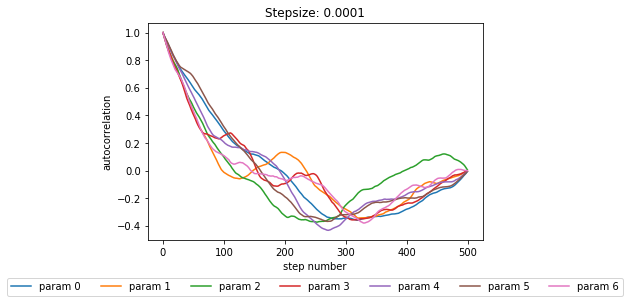

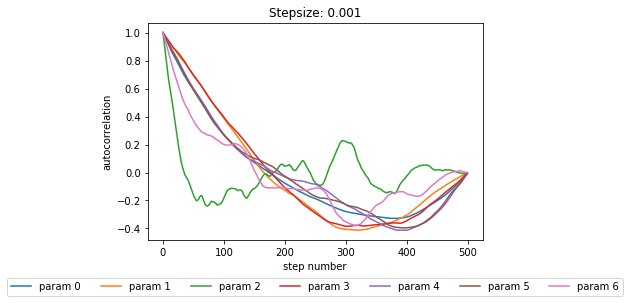

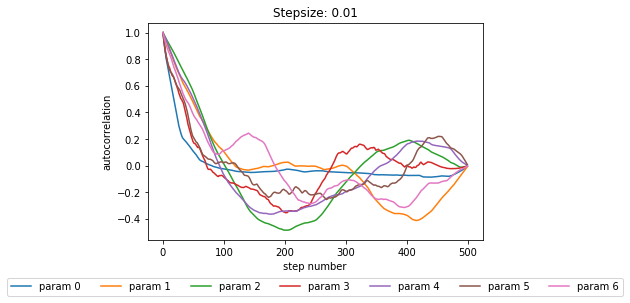

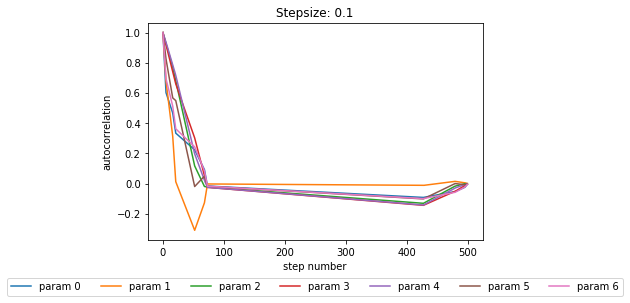

In [158]:
scales = [0.0001, 0.001, 0.01, 0.1]
nsteps = 500
nparams = 7
corr_length = np.zeros((len(scales), len(chain[0])))
chains = np.zeros((len(scales), nsteps, nparams))
falsecounts = np.zeros(len(scales))

for i in range(len(scales)):
    plt.figure()
    stepscale = scales[i]
               
    stepsize = np.asarray([0.02*stepscale, 0.12*stepscale, 2.12e-9*stepscale, 70*stepscale, 1*stepscale, 0.05*stepscale])
    result = mcmc(wmap, cosmology, params, stepsize, nsteps)
    chain = result[0]
    falsecounts[i] = result[1]
    chains[i,:,:] = chain
    for par in range(len(chain[0])):
        corr_length[i,par] = minimize_corr_length(chain[:,par], 0.05)
        corr = []
        for lag in range(nsteps):
            corr.append(autocorrelate(lag, chain[:,par]))
        plt.plot(range(nsteps), corr, label='param ' + str(par))
        plt.title('Stepsize: ' + str(stepscale))
        plt.xlabel('step number')
        plt.ylabel('autocorrelation')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
        

Below: the correlation length for each variable, for each of the chains with different scalings.

Below that: the number of False steps (out of 500). A reasonable amount seems like 125 out of 500, corresponding to a stepsize of 0.001.

In [160]:
print(corr_length)
print(falsecounts)

[[184. 101. 119. 160. 192. 162. 139.]
 [168. 166. 162. 176. 175. 187. 157.]
 [ 70. 119. 106.  78. 346.  85. 189.]
 [ 80.  75.  70.  79.  76.  59.  80.]]
[ 45. 125. 416. 497.]


In [28]:
stepscale = 0.001
stepsize = np.asarray([0.02*stepscale, 0.12*stepscale, 2.12e-9*stepscale, 70*stepscale, 1*stepscale, 0.05*stepscale])

result_all = mcmc(wmap, cosmology, params, stepsize, 1000)

0
(1486.5314453775582, 1486.5314453775582, 92.90884931515525, 0.8960918735189008, array([2.00535664e-02, 1.20006503e-01, 2.12381138e-09, 6.99432917e+01,
       9.99847578e-01, 4.99606486e-02]), array([2.00535664e-02, 1.20006503e-01, 2.12381138e-09, 6.99432917e+01,
       9.99847578e-01, 4.99606486e-02]), True)
1
(1486.5314453775582, 1490.8791201083623, 0.11374031525375786, 0.5493109666553128, array([2.00535664e-02, 1.20006503e-01, 2.12381138e-09, 6.99432917e+01,
       9.99847578e-01, 4.99606486e-02]), array([2.00198871e-02, 1.19899421e-01, 2.12367253e-09, 7.00548259e+01,
       9.99326917e-01, 4.99799095e-02]), False)
2
(1482.919617990834, 1482.919617990834, 6.08552921673575, 0.11586719444082894, array([2.00536244e-02, 1.19960899e-01, 2.12309250e-09, 6.99259663e+01,
       9.99084291e-01, 4.99190403e-02]), array([2.00536244e-02, 1.19960899e-01, 2.12309250e-09, 6.99259663e+01,
       9.99084291e-01, 4.99190403e-02]), True)
3
(1477.6522742442974, 1477.6522742442974, 13.924806269158228, 

(1448.7780775204, 1453.1356921857232, 0.11317643201217069, 0.5588632013668222, array([2.00312710e-02, 1.18633853e-01, 2.12631019e-09, 6.96805784e+01,
       9.92384496e-01, 5.01256870e-02]), array([2.00397643e-02, 1.18694241e-01, 2.12919710e-09, 6.96985773e+01,
       9.93485564e-01, 5.01163205e-02]), False)
28
(1448.7780775204, 1453.3596761124186, 0.10118555231469577, 0.1541231061093793, array([2.00312710e-02, 1.18633853e-01, 2.12631019e-09, 6.96805784e+01,
       9.92384496e-01, 5.01256870e-02]), array([2.00239103e-02, 1.18551557e-01, 2.13085788e-09, 6.95635640e+01,
       9.93711814e-01, 5.00566022e-02]), False)
29
(1439.136107095158, 1439.136107095158, 124.08728293457301, 0.15858792811905587, array([2.00731930e-02, 1.18424380e-01, 2.12360119e-09, 6.96434728e+01,
       9.92074281e-01, 5.01509763e-02]), array([2.00731930e-02, 1.18424380e-01, 2.12360119e-09, 6.96434728e+01,
       9.92074281e-01, 5.01509763e-02]), True)
30
(1438.7508218652201, 1438.7508218652201, 1.2124494048121897, 

(1405.2709385951664, 1405.2709385951664, 103.64581313987631, 0.6647105532886242, array([2.01993901e-02, 1.18049864e-01, 2.11942884e-09, 6.93452650e+01,
       9.87993081e-01, 4.99450334e-02]), array([2.01993901e-02, 1.18049864e-01, 2.11942884e-09, 6.93452650e+01,
       9.87993081e-01, 4.99450334e-02]), True)
55
(1403.7076602727277, 1403.7076602727277, 2.1850509824826423, 0.4187569202969815, array([2.01951979e-02, 1.17948517e-01, 2.11703179e-09, 6.92747171e+01,
       9.88656815e-01, 4.99661679e-02]), array([2.01951979e-02, 1.17948517e-01, 2.11703179e-09, 6.92747171e+01,
       9.88656815e-01, 4.99661679e-02]), True)
56
(1403.7076602727277, 1408.1519128933544, 0.10837841750432438, 0.9213002533655993, array([2.01951979e-02, 1.17948517e-01, 2.11703179e-09, 6.92747171e+01,
       9.88656815e-01, 4.99661679e-02]), array([2.01779911e-02, 1.17757818e-01, 2.11830813e-09, 6.92986254e+01,
       9.89409006e-01, 4.98857585e-02]), False)
57
(1403.7076602727277, 1406.105198575428, 0.30156516464779

(1394.1381360913217, 1394.1381360913217, 0.24528541132802378, 0.17528067555052407, array([2.02347911e-02, 1.17516881e-01, 2.10978994e-09, 6.96873932e+01,
       9.84964173e-01, 4.97485027e-02]), array([2.02347911e-02, 1.17516881e-01, 2.10978994e-09, 6.96873932e+01,
       9.84964173e-01, 4.97485027e-02]), True)
82
(1394.1381360913217, 1399.9366410136108, 0.05506436742906482, 0.16214398176284572, array([2.02347911e-02, 1.17516881e-01, 2.10978994e-09, 6.96873932e+01,
       9.84964173e-01, 4.97485027e-02]), array([2.01918945e-02, 1.17506612e-01, 2.11060181e-09, 6.96614308e+01,
       9.85656276e-01, 4.97860345e-02]), False)
83
(1386.5468759928456, 1386.5468759928456, 44.50626871442688, 0.4142634870684766, array([2.02378540e-02, 1.17554236e-01, 2.10439920e-09, 6.97316216e+01,
       9.82412412e-01, 4.97669590e-02]), array([2.02378540e-02, 1.17554236e-01, 2.10439920e-09, 6.97316216e+01,
       9.82412412e-01, 4.97669590e-02]), True)
84
(1386.5468759928456, 1392.0713210117938, 0.06315125800

(1357.962628679012, 1357.962628679012, 8.549703719553374, 0.046757545226951636, array([2.05030412e-02, 1.17556564e-01, 2.08382914e-09, 6.99497351e+01,
       9.81211635e-01, 4.96822599e-02]), array([2.05030412e-02, 1.17556564e-01, 2.08382914e-09, 6.99497351e+01,
       9.81211635e-01, 4.96822599e-02]), True)
109
(1357.962628679012, 1361.4280019593648, 0.1768087498013669, 0.31797165531718297, array([2.05030412e-02, 1.17556564e-01, 2.08382914e-09, 6.99497351e+01,
       9.81211635e-01, 4.96822599e-02]), array([2.05138125e-02, 1.17660342e-01, 2.07955429e-09, 7.00581500e+01,
       9.81279252e-01, 4.95956023e-02]), False)
110
(1355.246158728931, 1355.246158728931, 3.889322488732246, 0.0023399203943040847, array([2.05326037e-02, 1.17544246e-01, 2.08094135e-09, 7.00068660e+01,
       9.80528182e-01, 4.97356969e-02]), array([2.05326037e-02, 1.17544246e-01, 2.08094135e-09, 7.00068660e+01,
       9.80528182e-01, 4.97356969e-02]), True)
111
(1355.246158728931, 1355.3285822303346, 0.9596259069729

(1309.0241646776317, 1309.0241646776317, 0.764608372966274, 0.1784376608737558, array([2.08017637e-02, 1.16639161e-01, 2.07078704e-09, 6.94940566e+01,
       9.77011780e-01, 5.01492323e-02]), array([2.08017637e-02, 1.16639161e-01, 2.07078704e-09, 6.94940566e+01,
       9.77011780e-01, 5.01492323e-02]), True)
136
(1309.6143101641296, 1309.6143101641296, 0.744477429789106, 0.2577992578210806, array([2.08137634e-02, 1.16702448e-01, 2.07484775e-09, 6.94818627e+01,
       9.77985700e-01, 5.00986516e-02]), array([2.08137634e-02, 1.16702448e-01, 2.07484775e-09, 6.94818627e+01,
       9.77985700e-01, 5.00986516e-02]), True)
137
(1304.4526156480886, 1304.4526156480886, 13.208324278907586, 0.953282811986574, array([2.08371815e-02, 1.16593491e-01, 2.07646878e-09, 6.94738292e+01,
       9.76615171e-01, 5.00937818e-02]), array([2.08371815e-02, 1.16593491e-01, 2.07646878e-09, 6.94738292e+01,
       9.76615171e-01, 5.00937818e-02]), True)
138
(1304.4526156480886, 1306.3744124050345, 0.382549057715979

(1277.069416741788, 1277.069416741788, 0.5792847624596975, 0.06690849677418875, array([2.08943805e-02, 1.16444408e-01, 2.06851319e-09, 6.87334899e+01,
       9.68257603e-01, 5.04950876e-02]), array([2.08943805e-02, 1.16444408e-01, 2.06851319e-09, 6.87334899e+01,
       9.68257603e-01, 5.04950876e-02]), True)
163
(1277.2067725323686, 1277.2067725323686, 0.9336273574197317, 0.47038711800623423, array([2.08809047e-02, 1.16433647e-01, 2.07010689e-09, 6.87127387e+01,
       9.67817850e-01, 5.04939997e-02]), array([2.08809047e-02, 1.16433647e-01, 2.07010689e-09, 6.87127387e+01,
       9.67817850e-01, 5.04939997e-02]), True)
164
(1277.1458964160988, 1277.1458964160988, 1.0309060318287036, 0.35207244532105986, array([2.08969652e-02, 1.16331679e-01, 2.06547319e-09, 6.88642741e+01,
       9.67682107e-01, 5.04707865e-02]), array([2.08969652e-02, 1.16331679e-01, 2.06547319e-09, 6.88642741e+01,
       9.67682107e-01, 5.04707865e-02]), True)
165
(1273.6434722466315, 1273.6434722466315, 5.76158197095

(1258.9518937809025, 1258.9518937809025, 3.778177438013647, 0.24648059655300358, array([2.09836627e-02, 1.16840559e-01, 2.05706563e-09, 6.79060640e+01,
       9.62416903e-01, 5.01415324e-02]), array([2.09836627e-02, 1.16840559e-01, 2.05706563e-09, 6.79060640e+01,
       9.62416903e-01, 5.01415324e-02]), True)
190
(1258.6224822101658, 1258.6224822101658, 1.1790461750398757, 0.8673756959813668, array([2.09977965e-02, 1.16873973e-01, 2.05505731e-09, 6.78066084e+01,
       9.62997886e-01, 5.01493995e-02]), array([2.09977965e-02, 1.16873973e-01, 2.05505731e-09, 6.78066084e+01,
       9.62997886e-01, 5.01493995e-02]), True)
191
(1258.250751633007, 1258.250751633007, 1.2042600218718758, 0.37992866832309724, array([2.10082962e-02, 1.16884044e-01, 2.05675354e-09, 6.77882451e+01,
       9.63439123e-01, 5.01983684e-02]), array([2.10082962e-02, 1.16884044e-01, 2.05675354e-09, 6.77882451e+01,
       9.63439123e-01, 5.01983684e-02]), True)
192
(1257.0535581675097, 1257.0535581675097, 1.8195636739317

(1255.7324586325303, 1255.7324586325303, 2.7676466658549157, 0.5971012467991661, array([2.11585795e-02, 1.16931165e-01, 2.05765662e-09, 6.78766886e+01,
       9.66181247e-01, 5.01627167e-02]), array([2.11585795e-02, 1.16931165e-01, 2.05765662e-09, 6.78766886e+01,
       9.66181247e-01, 5.01627167e-02]), True)
217
(1256.0069847318005, 1256.0069847318005, 0.8717408848477294, 0.7012820274103196, array([2.11443308e-02, 1.16771583e-01, 2.05751482e-09, 6.80133039e+01,
       9.65706125e-01, 5.01329814e-02]), array([2.11443308e-02, 1.16771583e-01, 2.05751482e-09, 6.80133039e+01,
       9.65706125e-01, 5.01329814e-02]), True)
218
(1253.478930160063, 1253.478930160063, 3.5396479953815883, 0.29117491253411276, array([2.11431699e-02, 1.16562062e-01, 2.05899811e-09, 6.79463069e+01,
       9.64977841e-01, 5.01743887e-02]), array([2.11431699e-02, 1.16562062e-01, 2.05899811e-09, 6.79463069e+01,
       9.64977841e-01, 5.01743887e-02]), True)
219
(1253.478930160063, 1256.680667656628, 0.201721196907390

(1246.0446053727176, 1246.0446053727176, 0.8270382867077355, 0.28212527379373165, array([2.11965985e-02, 1.15991891e-01, 2.05664677e-09, 6.79421486e+01,
       9.60536860e-01, 5.04045503e-02]), array([2.11965985e-02, 1.15991891e-01, 2.05664677e-09, 6.79421486e+01,
       9.60536860e-01, 5.04045503e-02]), True)
244
(1246.619183120982, 1246.619183120982, 0.7502949567241499, 0.3777106075919272, array([2.11806400e-02, 1.15931390e-01, 2.05617169e-09, 6.80258552e+01,
       9.59867527e-01, 5.03803066e-02]), array([2.11806400e-02, 1.15931390e-01, 2.05617169e-09, 6.80258552e+01,
       9.59867527e-01, 5.03803066e-02]), True)
245
(1246.2161507423612, 1246.2161507423612, 1.2232560405742245, 0.83930928881804, array([2.11894132e-02, 1.16176084e-01, 2.05892909e-09, 6.80121926e+01,
       9.57981870e-01, 5.03974759e-02]), array([2.11894132e-02, 1.16176084e-01, 2.05892909e-09, 6.80121926e+01,
       9.57981870e-01, 5.03974759e-02]), True)
246
(1245.1451205978462, 1245.1451205978462, 1.708327928006249

(1245.7504890139667, 1245.7504890139667, 0.6087477870110439, 0.3030357726925861, array([2.12562453e-02, 1.16532362e-01, 2.05683015e-09, 6.83098790e+01,
       9.55869361e-01, 5.02642720e-02]), array([2.12562453e-02, 1.16532362e-01, 2.05683015e-09, 6.83098790e+01,
       9.55869361e-01, 5.02642720e-02]), True)
271
(1244.0901001698558, 1244.0901001698558, 2.2937646553539404, 0.8616184656937965, array([2.12732432e-02, 1.16450336e-01, 2.05674486e-09, 6.82304312e+01,
       9.54408140e-01, 5.02565334e-02]), array([2.12732432e-02, 1.16450336e-01, 2.05674486e-09, 6.82304312e+01,
       9.54408140e-01, 5.02565334e-02]), True)
272
(1246.2675217260996, 1246.2675217260996, 0.33665023089784823, 0.008261961124659933, array([2.12428243e-02, 1.16451145e-01, 2.05671954e-09, 6.83836286e+01,
       9.54477367e-01, 5.02752822e-02]), array([2.12428243e-02, 1.16451145e-01, 2.05671954e-09, 6.83836286e+01,
       9.54477367e-01, 5.02752822e-02]), True)
273
(1245.6845656511337, 1245.6845656511337, 1.338404238

(1240.8053072563534, 1240.8053072563534, 1.1344461836948683, 0.780619935225175, array([2.14119711e-02, 1.17148541e-01, 2.05427416e-09, 6.81799813e+01,
       9.52663082e-01, 5.01494837e-02]), array([2.14119711e-02, 1.17148541e-01, 2.05427416e-09, 6.81799813e+01,
       9.52663082e-01, 5.01494837e-02]), True)
298
(1241.4748555604851, 1241.4748555604851, 0.7154996622266853, 0.6820307873609728, array([2.14051030e-02, 1.16922790e-01, 2.05069572e-09, 6.83210060e+01,
       9.52488577e-01, 5.01235941e-02]), array([2.14051030e-02, 1.16922790e-01, 2.05069572e-09, 6.83210060e+01,
       9.52488577e-01, 5.01235941e-02]), True)
299
(1240.9637129857242, 1240.9637129857242, 1.2911990559354818, 0.054933886536347454, array([2.14165714e-02, 1.16916523e-01, 2.05250519e-09, 6.83243673e+01,
       9.51030458e-01, 5.01295409e-02]), array([2.14165714e-02, 1.16916523e-01, 2.05250519e-09, 6.83243673e+01,
       9.51030458e-01, 5.01295409e-02]), True)
300
(1241.7242260679327, 1241.7242260679327, 0.68368599315

(1241.2013764123153, 1241.2013764123153, 1.0698864864934108, 0.663141856543403, array([2.15712015e-02, 1.17296504e-01, 2.05414487e-09, 6.86238851e+01,
       9.52782015e-01, 4.99928505e-02]), array([2.15712015e-02, 1.17296504e-01, 2.05414487e-09, 6.86238851e+01,
       9.52782015e-01, 4.99928505e-02]), True)
325
(1240.5954966303534, 1240.5954966303534, 1.3538330844178164, 0.8537984251825577, array([2.15896318e-02, 1.17111780e-01, 2.05247450e-09, 6.86498519e+01,
       9.54042434e-01, 5.00342297e-02]), array([2.15896318e-02, 1.17111780e-01, 2.05247450e-09, 6.86498519e+01,
       9.54042434e-01, 5.00342297e-02]), True)
326
(1241.2722149179733, 1241.2722149179733, 0.7129391942153291, 0.28050959758388283, array([2.15716131e-02, 1.17183502e-01, 2.05151353e-09, 6.85258980e+01,
       9.56450874e-01, 5.00491482e-02]), array([2.15716131e-02, 1.17183502e-01, 2.05151353e-09, 6.85258980e+01,
       9.56450874e-01, 5.00491482e-02]), True)
327
(1241.2722149179733, 1241.8915360633168, 0.733695950420

(1237.6521580226963, 1237.6521580226963, 3.4830746116755305, 0.2539610354013282, array([2.16602692e-02, 1.17428654e-01, 2.04856983e-09, 6.80435871e+01,
       9.56889846e-01, 4.99129324e-02]), array([2.16602692e-02, 1.17428654e-01, 2.04856983e-09, 6.80435871e+01,
       9.56889846e-01, 4.99129324e-02]), True)
351
(1237.6521580226963, 1238.334443003093, 0.7109575964997046, 0.7728520671508308, array([2.16602692e-02, 1.17428654e-01, 2.04856983e-09, 6.80435871e+01,
       9.56889846e-01, 4.99129324e-02]), array([2.16322504e-02, 1.17545603e-01, 2.04709587e-09, 6.80166903e+01,
       9.55583853e-01, 4.97680634e-02]), False)
352
(1237.4223641952767, 1237.4223641952767, 1.1217577937619323, 0.35531753250611986, array([2.16707809e-02, 1.17556424e-01, 2.04983062e-09, 6.80163474e+01,
       9.56746102e-01, 4.99288592e-02]), array([2.16707809e-02, 1.17556424e-01, 2.04983062e-09, 6.80163474e+01,
       9.56746102e-01, 4.99288592e-02]), True)
353
(1237.4223641952767, 1239.0783543542398, 0.43692440746

(1234.4362217579185, 1234.4362217579185, 0.8897094222001093, 0.3281708646146382, array([2.16178954e-02, 1.16901880e-01, 2.04920664e-09, 6.79102820e+01,
       9.54709204e-01, 5.01445528e-02]), array([2.16178954e-02, 1.16901880e-01, 2.04920664e-09, 6.79102820e+01,
       9.54709204e-01, 5.01445528e-02]), True)
378
(1234.7654957299346, 1234.7654957299346, 0.8482015572402836, 0.14792932381246415, array([2.16185964e-02, 1.17057038e-01, 2.04874484e-09, 6.79404338e+01,
       9.52740785e-01, 5.01896350e-02]), array([2.16185964e-02, 1.17057038e-01, 2.04874484e-09, 6.79404338e+01,
       9.52740785e-01, 5.01896350e-02]), True)
379
(1233.5520822155793, 1233.5520822155793, 1.834380380492727, 0.8232379676710381, array([2.16385357e-02, 1.16821268e-01, 2.04685079e-09, 6.78943216e+01,
       9.51236830e-01, 5.01732381e-02]), array([2.16385357e-02, 1.16821268e-01, 2.04685079e-09, 6.78943216e+01,
       9.51236830e-01, 5.01732381e-02]), True)
380
(1233.948753928756, 1233.948753928756, 0.82009437278125

(1232.1354079552034, 1233.3167179182283, 0.5539643294886265, 0.6226849231553813, array([2.17621659e-02, 1.16830338e-01, 2.04724068e-09, 6.78520149e+01,
       9.49817635e-01, 5.00447417e-02]), array([2.17487099e-02, 1.16980646e-01, 2.04743743e-09, 6.79330689e+01,
       9.47969536e-01, 5.00386792e-02]), False)
405
(1231.9784985981205, 1231.9784985981205, 1.0816143337122284, 0.7583123732233256, array([2.17635933e-02, 1.16898466e-01, 2.04551886e-09, 6.77303187e+01,
       9.48875248e-01, 5.00440359e-02]), array([2.17635933e-02, 1.16898466e-01, 2.04551886e-09, 6.77303187e+01,
       9.48875248e-01, 5.00440359e-02]), True)
406
(1232.010458979248, 1232.010458979248, 0.9841468152558273, 0.5897245124117713, array([2.17725772e-02, 1.16998856e-01, 2.04533055e-09, 6.76546083e+01,
       9.48041457e-01, 5.00502496e-02]), array([2.17725772e-02, 1.16998856e-01, 2.04533055e-09, 6.76546083e+01,
       9.48041457e-01, 5.00502496e-02]), True)
407
(1231.9381493296894, 1231.9381493296894, 1.0368163589288

(1233.2831677851, 1233.2831677851, 1.184052646815242, 0.4365008472670717, array([2.17845017e-02, 1.17634167e-01, 2.06363187e-09, 6.79397450e+01,
       9.56814322e-01, 5.01184409e-02]), array([2.17845017e-02, 1.17634167e-01, 2.06363187e-09, 6.79397450e+01,
       9.56814322e-01, 5.01184409e-02]), True)
432
(1232.5902950055338, 1232.5902950055338, 1.414019544879597, 0.5761300225564677, array([2.17962761e-02, 1.17713036e-01, 2.06278210e-09, 6.78146311e+01,
       9.56428468e-01, 5.00215714e-02]), array([2.17962761e-02, 1.17713036e-01, 2.06278210e-09, 6.78146311e+01,
       9.56428468e-01, 5.00215714e-02]), True)
433
(1233.0974071925668, 1233.0974071925668, 0.7760362131040802, 0.7384944871165513, array([2.17557508e-02, 1.17703176e-01, 2.06130147e-09, 6.78169004e+01,
       9.54683626e-01, 5.00231992e-02]), array([2.17557508e-02, 1.17703176e-01, 2.06130147e-09, 6.78169004e+01,
       9.54683626e-01, 5.00231992e-02]), True)
434
(1232.8370557221847, 1232.8370557221847, 1.139028533134333, 0.5

(1231.695408879419, 1231.695408879419, 1.348187390242898, 0.780892556785412, array([2.19244801e-02, 1.17731132e-01, 2.05825881e-09, 6.78684311e+01,
       9.52742917e-01, 4.97596728e-02]), array([2.19244801e-02, 1.17731132e-01, 2.05825881e-09, 6.78684311e+01,
       9.52742917e-01, 4.97596728e-02]), True)
459
(1231.7401436698392, 1231.7401436698392, 0.9778809002874502, 0.9315691953015874, array([2.19013455e-02, 1.17893247e-01, 2.05706227e-09, 6.78002587e+01,
       9.52845901e-01, 4.97174160e-02]), array([2.19013455e-02, 1.17893247e-01, 2.05706227e-09, 6.78002587e+01,
       9.52845901e-01, 4.97174160e-02]), True)
460
(1231.7718938719663, 1231.7718938719663, 0.9842502441872715, 0.3652315558269116, array([2.18843516e-02, 1.17887595e-01, 2.05923165e-09, 6.78018572e+01,
       9.53794480e-01, 4.97611149e-02]), array([2.18843516e-02, 1.17887595e-01, 2.05923165e-09, 6.78018572e+01,
       9.53794480e-01, 4.97611149e-02]), True)
461
(1231.8634830457295, 1231.8634830457295, 0.9552381604885485

(1231.119417582746, 1231.119417582746, 1.17676806580081, 0.2025385938262213, array([2.20101178e-02, 1.18038688e-01, 2.05567493e-09, 6.76863090e+01,
       9.55914125e-01, 5.00313274e-02]), array([2.20101178e-02, 1.18038688e-01, 2.05567493e-09, 6.76863090e+01,
       9.55914125e-01, 5.00313274e-02]), True)
485
(1231.4003405122203, 1231.4003405122203, 0.8689571497798261, 0.04097262499967469, array([2.20045672e-02, 1.18108116e-01, 2.05602212e-09, 6.76767383e+01,
       9.56432152e-01, 5.00732900e-02]), array([2.20045672e-02, 1.18108116e-01, 2.05602212e-09, 6.76767383e+01,
       9.56432152e-01, 5.00732900e-02]), True)
486
(1231.5943202606081, 1231.5943202606081, 0.9075651959159214, 0.812041669677029, array([2.19978989e-02, 1.18156310e-01, 2.05668445e-09, 6.76858073e+01,
       9.56747866e-01, 5.00972627e-02]), array([2.19978989e-02, 1.18156310e-01, 2.05668445e-09, 6.76858073e+01,
       9.56747866e-01, 5.00972627e-02]), True)
487
(1231.3252336426413, 1231.3252336426413, 1.144014204021731,

(1230.340367870312, 1230.7933196234399, 0.7973385766272052, 0.861027685339512, array([2.21203326e-02, 1.17883627e-01, 2.07217602e-09, 6.76942811e+01,
       9.58773160e-01, 5.02714274e-02]), array([2.21115933e-02, 1.17913570e-01, 2.07470972e-09, 6.77388010e+01,
       9.59730325e-01, 5.02623097e-02]), False)
512
(1230.8615044659755, 1230.8615044659755, 0.7706135233459903, 0.6874032704107592, array([2.20949550e-02, 1.17801352e-01, 2.07140317e-09, 6.77734784e+01,
       9.57557046e-01, 5.03099942e-02]), array([2.20949550e-02, 1.17801352e-01, 2.07140317e-09, 6.77734784e+01,
       9.57557046e-01, 5.03099942e-02]), True)
513
(1230.222506019383, 1230.222506019383, 1.3764383034808627, 0.7181598230885211, array([2.20611444e-02, 1.17731207e-01, 2.06801041e-09, 6.77519692e+01,
       9.57634445e-01, 5.02706365e-02]), array([2.20611444e-02, 1.17731207e-01, 2.06801041e-09, 6.77519692e+01,
       9.57634445e-01, 5.02706365e-02]), True)
514
(1230.0950783736344, 1230.0950783736344, 1.065787351154023

(1232.6306434006258, 1232.6306434006258, 1.9680800994592325, 0.10068389260179988, array([2.21493134e-02, 1.17542484e-01, 2.07480795e-09, 6.76107094e+01,
       9.57086544e-01, 5.05558973e-02]), array([2.21493134e-02, 1.17542484e-01, 2.07480795e-09, 6.76107094e+01,
       9.57086544e-01, 5.05558973e-02]), True)
539
(1232.2122032553934, 1232.2122032553934, 1.2327162557724256, 0.43172631121264105, array([2.21324523e-02, 1.17638352e-01, 2.07324623e-09, 6.77927423e+01,
       9.56165851e-01, 5.05637605e-02]), array([2.21324523e-02, 1.17638352e-01, 2.07324623e-09, 6.77927423e+01,
       9.56165851e-01, 5.05637605e-02]), True)
540
(1231.279961617765, 1231.279961617765, 1.5937995486881011, 0.5454105997526387, array([2.21473879e-02, 1.17435389e-01, 2.07140541e-09, 6.78411168e+01,
       9.57410391e-01, 5.05821996e-02]), array([2.21473879e-02, 1.17435389e-01, 2.07140541e-09, 6.78411168e+01,
       9.57410391e-01, 5.05821996e-02]), True)
541
(1230.1246296687186, 1230.1246296687186, 1.781874632645

(1230.4410532865268, 1230.4410532865268, 1.5942317767917207, 0.383162741908073, array([2.22118493e-02, 1.17876306e-01, 2.06239675e-09, 6.79438283e+01,
       9.55090468e-01, 5.07390749e-02]), array([2.22118493e-02, 1.17876306e-01, 2.06239675e-09, 6.79438283e+01,
       9.55090468e-01, 5.07390749e-02]), True)
566
(1230.1096472327463, 1230.1096472327463, 1.1802225553119656, 0.08329616134366102, array([2.21860673e-02, 1.17914343e-01, 2.06224320e-09, 6.78263886e+01,
       9.55417022e-01, 5.07291192e-02]), array([2.21860673e-02, 1.17914343e-01, 2.06224320e-09, 6.78263886e+01,
       9.55417022e-01, 5.07291192e-02]), True)
567
(1229.969481334101, 1229.969481334101, 1.072597148771269, 0.49510824337613235, array([2.22302009e-02, 1.17905013e-01, 2.06432678e-09, 6.79301431e+01,
       9.56560296e-01, 5.06814121e-02]), array([2.22302009e-02, 1.17905013e-01, 2.06432678e-09, 6.79301431e+01,
       9.56560296e-01, 5.06814121e-02]), True)
568
(1229.969481334101, 1231.0264070361707, 0.589510438940645

(1229.403534867956, 1229.403534867956, 1.1138602716178643, 0.8350712510734691, array([2.22769537e-02, 1.17227707e-01, 2.05499930e-09, 6.76582776e+01,
       9.57304924e-01, 5.05494677e-02]), array([2.22769537e-02, 1.17227707e-01, 2.05499930e-09, 6.76582776e+01,
       9.57304924e-01, 5.05494677e-02]), True)
593
(1229.7956631763989, 1229.7956631763989, 0.8219595008148547, 0.6271183971502127, array([2.22827773e-02, 1.17181544e-01, 2.05406609e-09, 6.75997484e+01,
       9.56038633e-01, 5.06327396e-02]), array([2.22827773e-02, 1.17181544e-01, 2.05406609e-09, 6.75997484e+01,
       9.56038633e-01, 5.06327396e-02]), True)
594
(1230.2848125206074, 1230.2848125206074, 0.7830375151232712, 0.3650872839464053, array([2.22753127e-02, 1.17093254e-01, 2.04986036e-09, 6.76467100e+01,
       9.55449991e-01, 5.05599340e-02]), array([2.22753127e-02, 1.17093254e-01, 2.04986036e-09, 6.76467100e+01,
       9.55449991e-01, 5.05599340e-02]), True)
595
(1230.5385431911996, 1230.5385431911996, 0.88085228432262

(1231.4657716470638, 1231.4657716470638, 0.9588948609153943, 0.8139379200481955, array([2.22502276e-02, 1.16821085e-01, 2.04418164e-09, 6.78434114e+01,
       9.54661220e-01, 5.08147803e-02]), array([2.22502276e-02, 1.16821085e-01, 2.04418164e-09, 6.78434114e+01,
       9.54661220e-01, 5.08147803e-02]), True)
620
(1230.9734111704756, 1230.9734111704756, 1.2791301009934777, 0.5908107049064905, array([2.22457097e-02, 1.16895522e-01, 2.04617463e-09, 6.77702617e+01,
       9.54809979e-01, 5.08290492e-02]), array([2.22457097e-02, 1.16895522e-01, 2.04617463e-09, 6.77702617e+01,
       9.54809979e-01, 5.08290492e-02]), True)
621
(1230.8159238627773, 1230.8159238627773, 1.0819269387125563, 0.7740591585423879, array([2.22453486e-02, 1.16742788e-01, 2.04559723e-09, 6.77739577e+01,
       9.55248896e-01, 5.09071965e-02]), array([2.22453486e-02, 1.16742788e-01, 2.04559723e-09, 6.77739577e+01,
       9.55248896e-01, 5.09071965e-02]), True)
622
(1231.0366014670844, 1231.0366014670844, 0.895530676171

(1234.104707691899, 1234.104707691899, 0.8730534806102666, 0.6167269903536067, array([2.24550196e-02, 1.16940368e-01, 2.04250593e-09, 6.80958089e+01,
       9.57405898e-01, 5.07978578e-02]), array([2.24550196e-02, 1.16940368e-01, 2.04250593e-09, 6.80958089e+01,
       9.57405898e-01, 5.07978578e-02]), True)
647
(1235.9274729373155, 1235.9274729373155, 0.4019680694654162, 0.2656011916208607, array([2.24702888e-02, 1.17022531e-01, 2.04103996e-09, 6.81667485e+01,
       9.58992195e-01, 5.07972207e-02]), array([2.24702888e-02, 1.17022531e-01, 2.04103996e-09, 6.81667485e+01,
       9.58992195e-01, 5.07972207e-02]), True)
648
(1234.8132211772609, 1234.8132211772609, 1.745648081347555, 0.3567157759704953, array([2.24662581e-02, 1.17011519e-01, 2.04316212e-09, 6.81867620e+01,
       9.59750572e-01, 5.08315377e-02]), array([2.24662581e-02, 1.17011519e-01, 2.04316212e-09, 6.81867620e+01,
       9.59750572e-01, 5.08315377e-02]), True)
649
(1234.9464011876898, 1234.9464011876898, 0.935578705104655

(1229.3325037436437, 1229.3325037436437, 1.0982333780511973, 0.8563201314456433, array([2.24842322e-02, 1.16787235e-01, 2.05863702e-09, 6.86664815e+01,
       9.64670993e-01, 5.06948324e-02]), array([2.24842322e-02, 1.16787235e-01, 2.05863702e-09, 6.86664815e+01,
       9.64670993e-01, 5.06948324e-02]), True)
674
(1230.3569639913248, 1230.3569639913248, 0.5991578914644178, 0.5368058948249016, array([2.24604460e-02, 1.16847354e-01, 2.05549801e-09, 6.85293790e+01,
       9.66385974e-01, 5.06633159e-02]), array([2.24604460e-02, 1.16847354e-01, 2.05549801e-09, 6.85293790e+01,
       9.66385974e-01, 5.06633159e-02]), True)
675
(1229.2991400679393, 1229.2991400679393, 1.6970848104420142, 0.8258599231631587, array([2.24699667e-02, 1.16792791e-01, 2.05727314e-09, 6.84052228e+01,
       9.65714993e-01, 5.07072897e-02]), array([2.24699667e-02, 1.16792791e-01, 2.05727314e-09, 6.84052228e+01,
       9.65714993e-01, 5.07072897e-02]), True)
676
(1228.577065183511, 1228.577065183511, 1.43481718260508

(1228.9512545335988, 1229.4947071180984, 0.7620628150457286, 0.9419692787093296, array([2.24995431e-02, 1.17340708e-01, 2.06774998e-09, 6.77738128e+01,
       9.64829582e-01, 5.02992045e-02]), array([2.25361138e-02, 1.17122598e-01, 2.06602780e-09, 6.76788274e+01,
       9.65058119e-01, 5.03389225e-02]), False)
701
(1229.428188427849, 1229.428188427849, 0.7878347280295316, 0.006118998301198664, array([2.24893284e-02, 1.17492886e-01, 2.06420679e-09, 6.76728229e+01,
       9.61637595e-01, 5.03366094e-02]), array([2.24893284e-02, 1.17492886e-01, 2.06420679e-09, 6.76728229e+01,
       9.61637595e-01, 5.03366094e-02]), True)
702
(1229.5916437312328, 1229.5916437312328, 0.9215228997256856, 0.4374086936329601, array([2.25063061e-02, 1.17710467e-01, 2.06304963e-09, 6.77038709e+01,
       9.61088439e-01, 5.03040301e-02]), array([2.25063061e-02, 1.17710467e-01, 2.06304963e-09, 6.77038709e+01,
       9.61088439e-01, 5.03040301e-02]), True)
703
(1229.5916437312328, 1229.7939048576986, 0.90381502017

(1230.832234753233, 1230.832234753233, 1.0063471150937615, 0.4097964789875833, array([2.23657883e-02, 1.17893981e-01, 2.07997029e-09, 6.74275004e+01,
       9.63807225e-01, 5.04569088e-02]), array([2.23657883e-02, 1.17893981e-01, 2.07997029e-09, 6.74275004e+01,
       9.63807225e-01, 5.04569088e-02]), True)
727
(1230.3150726515228, 1230.3150726515228, 1.295091113841348, 0.43904249538622164, array([2.23763984e-02, 1.17935011e-01, 2.07895927e-09, 6.73993192e+01,
       9.64052785e-01, 5.04823570e-02]), array([2.23763984e-02, 1.17935011e-01, 2.07895927e-09, 6.73993192e+01,
       9.64052785e-01, 5.04823570e-02]), True)
728
(1230.1292414186373, 1230.1292414186373, 1.0973691314500607, 0.41153358074584123, array([2.23990197e-02, 1.17788511e-01, 2.08001175e-09, 6.75678998e+01,
       9.65809220e-01, 5.05759330e-02]), array([2.23990197e-02, 1.17788511e-01, 2.08001175e-09, 6.75678998e+01,
       9.65809220e-01, 5.05759330e-02]), True)
729
(1231.112758599328, 1231.112758599328, 0.611549982083713

(1229.2648076039184, 1229.2648076039184, 1.0829250383515823, 0.8973358676937463, array([2.25162390e-02, 1.18542542e-01, 2.08251360e-09, 6.76362018e+01,
       9.71407555e-01, 5.04946109e-02]), array([2.25162390e-02, 1.18542542e-01, 2.08251360e-09, 6.76362018e+01,
       9.71407555e-01, 5.04946109e-02]), True)
753
(1229.2648076039184, 1230.0191546988942, 0.6857970452133293, 0.7936402575950513, array([2.25162390e-02, 1.18542542e-01, 2.08251360e-09, 6.76362018e+01,
       9.71407555e-01, 5.04946109e-02]), array([2.25098928e-02, 1.18522413e-01, 2.08457330e-09, 6.75662776e+01,
       9.73976530e-01, 5.05063766e-02]), False)
754
(1230.005620788857, 1230.005620788857, 0.6904535403477116, 0.4585631016658013, array([2.25305334e-02, 1.18696714e-01, 2.08413965e-09, 6.75972305e+01,
       9.73925291e-01, 5.04408086e-02]), array([2.25305334e-02, 1.18696714e-01, 2.08413965e-09, 6.75972305e+01,
       9.73925291e-01, 5.04408086e-02]), True)
755
(1230.5602525727386, 1230.5602525727386, 0.7578150716224

(1232.0652457594924, 1233.1747070806887, 0.5742269023004362, 0.6143611872035061, array([2.25595044e-02, 1.18664804e-01, 2.09866380e-09, 6.79126752e+01,
       9.75525149e-01, 5.04870661e-02]), array([2.25511072e-02, 1.18500064e-01, 2.09942594e-09, 6.78536465e+01,
       9.74511538e-01, 5.04134408e-02]), False)
780
(1232.4394165865658, 1232.4394165865658, 0.8293728936878975, 0.6920726451374593, array([2.25956765e-02, 1.18647796e-01, 2.09979630e-09, 6.79343418e+01,
       9.75555180e-01, 5.04398595e-02]), array([2.25956765e-02, 1.18647796e-01, 2.09979630e-09, 6.79343418e+01,
       9.75555180e-01, 5.04398595e-02]), True)
781
(1232.4787707770029, 1232.4787707770029, 0.9805152352520927, 0.0458465202222198, array([2.26247841e-02, 1.18551566e-01, 2.09969996e-09, 6.79737921e+01,
       9.76150868e-01, 5.04325614e-02]), array([2.26247841e-02, 1.18551566e-01, 2.09969996e-09, 6.79737921e+01,
       9.76150868e-01, 5.04325614e-02]), True)
782
(1232.5927654367306, 1232.5927654367306, 0.94459659156

(1231.3976101298454, 1231.3976101298454, 0.9423594780213318, 0.8052421209733289, array([2.24549034e-02, 1.19594852e-01, 2.09719478e-09, 6.78254371e+01,
       9.73468385e-01, 5.02448850e-02]), array([2.24549034e-02, 1.19594852e-01, 2.09719478e-09, 6.78254371e+01,
       9.73468385e-01, 5.02448850e-02]), True)
807
(1231.3976101298454, 1232.5667487544608, 0.5573458521268726, 0.6273928677941896, array([2.24549034e-02, 1.19594852e-01, 2.09719478e-09, 6.78254371e+01,
       9.73468385e-01, 5.02448850e-02]), array([2.24419640e-02, 1.19681413e-01, 2.10226116e-09, 6.78622296e+01,
       9.72866046e-01, 5.01739160e-02]), False)
808
(1231.8893592422257, 1231.8893592422257, 0.7820203183808285, 0.4778873939343087, array([2.24400147e-02, 1.19398380e-01, 2.09868941e-09, 6.78576218e+01,
       9.73027204e-01, 5.01916565e-02]), array([2.24400147e-02, 1.19398380e-01, 2.09868941e-09, 6.78576218e+01,
       9.73027204e-01, 5.01916565e-02]), True)
809
(1231.922023646519, 1231.922023646519, 0.9838004451443

(1234.0065623659991, 1234.0065623659991, 1.5793043434763196, 0.5901574275901019, array([2.22677169e-02, 1.18885743e-01, 2.08878179e-09, 6.78819975e+01,
       9.75872897e-01, 5.02543392e-02]), array([2.22677169e-02, 1.18885743e-01, 2.08878179e-09, 6.78819975e+01,
       9.75872897e-01, 5.02543392e-02]), True)
834
(1233.9847298031823, 1233.9847298031823, 1.010976081408091, 0.1338301181499083, array([2.22636861e-02, 1.18959565e-01, 2.09104826e-09, 6.78316590e+01,
       9.75805090e-01, 5.02200624e-02]), array([2.22636861e-02, 1.18959565e-01, 2.09104826e-09, 6.78316590e+01,
       9.75805090e-01, 5.02200624e-02]), True)
835
(1234.191834396323, 1234.191834396323, 0.9016288694112957, 0.8250742778692545, array([2.22675713e-02, 1.18983310e-01, 2.09322830e-09, 6.77893597e+01,
       9.76234389e-01, 5.02064291e-02]), array([2.22675713e-02, 1.18983310e-01, 2.09322830e-09, 6.77893597e+01,
       9.76234389e-01, 5.02064291e-02]), True)
836
(1234.191834396323, 1235.9490448601823, 0.4153618412853239

(1231.5425249753234, 1231.5425249753234, 0.9220569282305109, 0.6979766594901131, array([2.23330546e-02, 1.19670832e-01, 2.09285112e-09, 6.79757347e+01,
       9.67254515e-01, 5.05227953e-02]), array([2.23330546e-02, 1.19670832e-01, 2.09285112e-09, 6.79757347e+01,
       9.67254515e-01, 5.05227953e-02]), True)
861
(1231.5425249753234, 1231.9380662302078, 0.8205580450515956, 0.9070645282300439, array([2.23330546e-02, 1.19670832e-01, 2.09285112e-09, 6.79757347e+01,
       9.67254515e-01, 5.05227953e-02]), array([2.23321336e-02, 1.19601517e-01, 2.09356683e-09, 6.80649884e+01,
       9.66860475e-01, 5.04704575e-02]), False)
862
(1231.694683460976, 1231.694683460976, 0.9267427659336037, 0.14737726940972884, array([2.23228583e-02, 1.19586362e-01, 2.09414975e-09, 6.79527455e+01,
       9.68260832e-01, 5.05529099e-02]), array([2.23228583e-02, 1.19586362e-01, 2.09414975e-09, 6.79527455e+01,
       9.68260832e-01, 5.05529099e-02]), True)
863
(1231.738005928202, 1231.738005928202, 0.97857168610029

(1237.2759541553355, 1237.2759541553355, 1.096793322108763, 0.6382641276020892, array([2.22565202e-02, 1.20034017e-01, 2.10253187e-09, 6.79454423e+01,
       9.76726306e-01, 5.07451982e-02]), array([2.22565202e-02, 1.20034017e-01, 2.10253187e-09, 6.79454423e+01,
       9.76726306e-01, 5.07451982e-02]), True)
887
(1237.9288535909727, 1237.9288535909727, 0.7214806517575738, 0.30592670062324634, array([2.22453689e-02, 1.19842144e-01, 2.10623788e-09, 6.79557094e+01,
       9.77587860e-01, 5.06659816e-02]), array([2.22453689e-02, 1.19842144e-01, 2.10623788e-09, 6.79557094e+01,
       9.77587860e-01, 5.06659816e-02]), True)
888
(1236.860102535105, 1236.860102535105, 1.7063823213761398, 0.3994828502169142, array([2.22687485e-02, 1.19729291e-01, 2.10314155e-09, 6.80160800e+01,
       9.77050172e-01, 5.06780624e-02]), array([2.22687485e-02, 1.19729291e-01, 2.10314155e-09, 6.80160800e+01,
       9.77050172e-01, 5.06780624e-02]), True)
889
(1236.6212526790407, 1236.6212526790407, 1.12684864614640

(1238.5977669928188, 1238.5977669928188, 1.010800139281841, 0.6086635263413882, array([2.22546206e-02, 1.20108208e-01, 2.11365134e-09, 6.78065499e+01,
       9.77250967e-01, 5.08070466e-02]), array([2.22546206e-02, 1.20108208e-01, 2.11365134e-09, 6.78065499e+01,
       9.77250967e-01, 5.08070466e-02]), True)
914
(1240.084623644375, 1240.084623644375, 0.4754810142435103, 0.13228403434786118, array([2.22479152e-02, 1.20080643e-01, 2.11728279e-09, 6.77405726e+01,
       9.77900225e-01, 5.08421429e-02]), array([2.22479152e-02, 1.20080643e-01, 2.11728279e-09, 6.77405726e+01,
       9.77900225e-01, 5.08421429e-02]), True)
915
(1240.2411071501951, 1240.2411071501951, 0.9247408407290175, 0.8096094389051339, array([2.22397024e-02, 1.19863395e-01, 2.11742029e-09, 6.76270195e+01,
       9.77305836e-01, 5.08785878e-02]), array([2.22397024e-02, 1.19863395e-01, 2.11742029e-09, 6.76270195e+01,
       9.77305836e-01, 5.08785878e-02]), True)
916
(1239.4725824811067, 1239.4725824811067, 1.46853063747019

(1237.5529933046905, 1237.5529933046905, 1.5443281387301624, 0.29963628278345456, array([2.21821513e-02, 1.20005831e-01, 2.10713810e-09, 6.73443284e+01,
       9.77534071e-01, 5.09466192e-02]), array([2.21821513e-02, 1.20005831e-01, 2.10713810e-09, 6.73443284e+01,
       9.77534071e-01, 5.09466192e-02]), True)
941
(1239.050263515384, 1239.050263515384, 0.47301172351816456, 0.3840427630647367, array([2.21577906e-02, 1.19840796e-01, 2.10569535e-09, 6.73313125e+01,
       9.79233537e-01, 5.08598904e-02]), array([2.21577906e-02, 1.19840796e-01, 2.10569535e-09, 6.73313125e+01,
       9.79233537e-01, 5.08598904e-02]), True)
942
(1240.4384841107199, 1240.4384841107199, 0.4995186732701951, 0.2957985575836046, array([2.21678201e-02, 1.19783963e-01, 2.10656580e-09, 6.74379006e+01,
       9.80897709e-01, 5.08584121e-02]), array([2.21678201e-02, 1.19783963e-01, 2.10656580e-09, 6.74379006e+01,
       9.80897709e-01, 5.08584121e-02]), True)
943
(1239.8249606164711, 1239.8249606164711, 1.359017139755

(1233.9547162186732, 1233.9547162186732, 1.0233168108789228, 0.371845874384956, array([2.21333551e-02, 1.19588126e-01, 2.10153601e-09, 6.70944898e+01,
       9.70543614e-01, 5.09782410e-02]), array([2.21333551e-02, 1.19588126e-01, 2.10153601e-09, 6.70944898e+01,
       9.70543614e-01, 5.09782410e-02]), True)
968
(1234.1837221421142, 1234.1837221421142, 0.8918092971243202, 0.05202698421877883, array([2.21256432e-02, 1.19671417e-01, 2.09943943e-09, 6.70475883e+01,
       9.72597177e-01, 5.10001463e-02]), array([2.21256432e-02, 1.19671417e-01, 2.09943943e-09, 6.70475883e+01,
       9.72597177e-01, 5.10001463e-02]), True)
969
(1234.3703677911021, 1234.3703677911021, 0.9108993921907188, 0.3708498754868669, array([2.21366433e-02, 1.19657949e-01, 2.09578201e-09, 6.70373564e+01,
       9.73658033e-01, 5.10075894e-02]), array([2.21366433e-02, 1.19657949e-01, 2.09578201e-09, 6.70373564e+01,
       9.73658033e-01, 5.10075894e-02]), True)
970
(1234.2131458303966, 1234.2131458303966, 1.081783405204

(1233.2776477113152, 1233.2776477113152, 1.4237783010767782, 0.341739324495404, array([2.21633897e-02, 1.20005891e-01, 2.08827169e-09, 6.66719562e+01,
       9.70777052e-01, 5.09270334e-02]), array([2.21633897e-02, 1.20005891e-01, 2.08827169e-09, 6.66719562e+01,
       9.70777052e-01, 5.09270334e-02]), True)
995
(1233.1445871562012, 1233.1445871562012, 1.0687933240361083, 0.40903170782308873, array([2.21470661e-02, 1.20029752e-01, 2.09051626e-09, 6.67677230e+01,
       9.70781215e-01, 5.09214471e-02]), array([2.21470661e-02, 1.20029752e-01, 2.09051626e-09, 6.67677230e+01,
       9.70781215e-01, 5.09214471e-02]), True)
996
(1231.8155920032648, 1231.8155920032648, 1.9435138089237318, 0.4890469339002027, array([2.21737105e-02, 1.19874890e-01, 2.09100787e-09, 6.68116587e+01,
       9.69674538e-01, 5.09074500e-02]), array([2.21737105e-02, 1.19874890e-01, 2.09100787e-09, 6.68116587e+01,
       9.69674538e-01, 5.09074500e-02]), True)
997
(1231.8929509349223, 1231.8929509349223, 0.962059032524

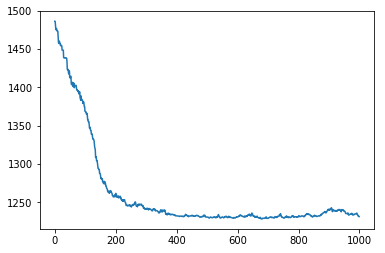

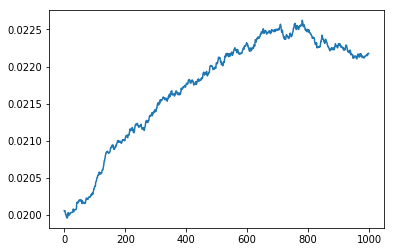

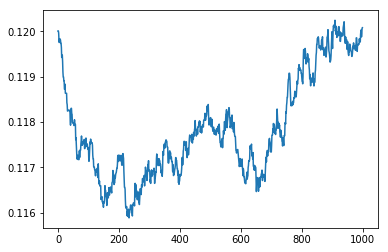

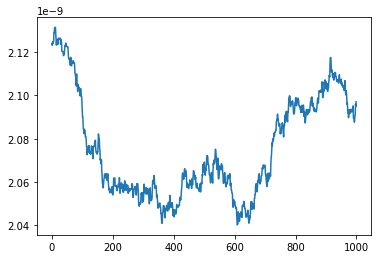

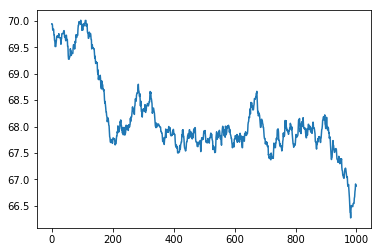

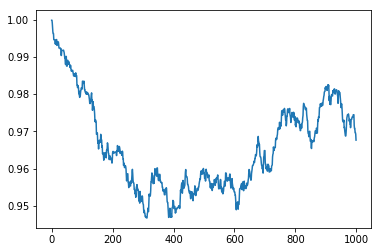

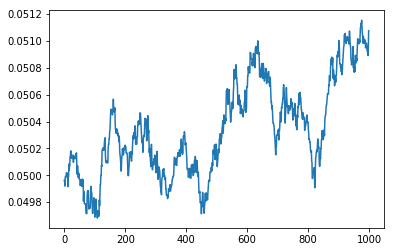

In [30]:
bigchain = result_all[0]
for i in range(0, len(bigchain[0])):
    plt.figure()
    plt.plot(bigchain[:,i])

## check the parameter estimates from the big chain
- it looks like it converges because the chi2 seems to stop decreasing? but some of the parameters still bounce around.

In [34]:
burnend = 400
for par in range(1, len(bigchain[:,1])-1):
    print('param #' + str(par) + ' mean: ' + str(np.mean(bigchain[burnend:,par])) + ' std: ' + str(np.std(bigchain[burnend:,par])))
    

param #1 mean: 0.022236913004334263 std: 0.0002148446396398959
param #2 mean: 0.1183348643574181 std: 0.0010507586792793907
param #3 mean: 2.0757465696906504e-09 std: 2.083069192010215e-11
param #4 mean: 67.74524112395855 std: 0.36138952470111385
param #5 mean: 0.9645364720415264 std: 0.009611903307438769
param #6 mean: 0.050501963108296126 std: 0.0003421987924658276


IndexError: index 7 is out of bounds for axis 1 with size 7

Ombh2 = 0.022, Omch2 = 0.12, As = 2.1e-9, H0 = 67.8, ns = 0.96, tau = 0.05